In [1]:
import os

os.environ["USE_PYGEOS"] = "0"

import dask
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

from matplotlib.colors import LinearSegmentedColormap

cm_data = np.loadtxt("../../ScientificColourMaps7/batlow/batlow.txt")[::-1]
batlow_map = LinearSegmentedColormap.from_list("batlow", cm_data)

cm_data = np.loadtxt("../../ScientificColourMaps7/bamako/bamako.txt")[::-1]
bamako_map = LinearSegmentedColormap.from_list("bamako", cm_data)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask

### Preliminaries

In [2]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
path_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/"
data_path = "/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/data/"

nex_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/"
cil_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/cil-gdpcir/"
isi_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/regridded/conservative/"
cbp_in = "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/carbonplan/"

poly_path = (
    "/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/forced_response/"
)

In [3]:
###################
# Models
###################
from utils import (
    cil_ssp_dict,
    deepsdbc_dict,
    gardsv_ssp_dict,
    gardsv_var_dict,
    isimip_ssp_dict,
    nex_ssp_dict,
)

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [
    model for model in cbp_gard_models if "pr" in gardsv_var_dict[model]
]
cbp_deep_models = list(deepsdbc_dict.keys())

In [12]:
################
# Cities
################
city_list = {
    "chicago": [41.881944, -87.627778],
    "lagos": [6.455027, 3.384082],
    "cairo": [30.044444, 31.235833],
    "seattle": [47.609722, -122.333056],
    "delhi": [28.613895, 77.209006],
    "houston": [29.762778, -95.383056],
    "mexicocity": [19.433333, -99.133333],
    "denver": [39.7392, -104.985],
    "nyc": [40.712778, -74.006111],
    "mumbai": [19.076111, 72.8775],
    "jakarta": [-6.175, 106.8275],
    "sanfrancisco": [37.7775, -122.416389],
    "rio": [-22.911111, -43.205556],
    "capetown": [33.925278, 18.423889],
}

In [13]:
##############################
# UC map plot
##############################
def plot_uc_map(metric, var_id, const_iav, deg, scenario_id, axs, fig, cbar, title, fs):
    # Setup read paths
    uc_read_path = (
        path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg) + ".nc"
    )
    iav_read_path = path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg)
    if const_iav:
        iav_read_path += "_const_iav.nc"
    else:
        iav_read_path += "_nonconst_iav.nc"

    if metric in ["hot", "wet", "hotdry"]:
        var_id_string = (
            var_id.replace("_count", "").replace("_streak", "").replace("pr_", "")
        )
        iav_read_path = iav_read_path.replace(metric, metric + "_" + var_id_string)
        uc_read_path = uc_read_path.replace(metric, metric + "_" + var_id_string)
    if metric == "hotdry":
        # This was me being silly
        iav_read_path = iav_read_path.replace("hotdry_hotdry_", "hotdry_")
        uc_read_path = uc_read_path.replace("hotdry_hotdry_", "hotdry_")

    # Averaging periods
    early_start, early_end = 2020, 2039
    mid_start, mid_end = 2050, 2069
    late_start, late_end = 2080, 2099

    # Read
    ds_uc = xr.open_dataset(uc_read_path)
    ds_iav = xr.open_dataset(iav_read_path)
    if const_iav:
        ds_iav_early = ds_iav.expand_dims(
            dim={"time": np.arange(early_start, early_end + 1)}
        ).assign_coords(uncertainty="variability")
        ds_iav_mid = ds_iav.expand_dims(
            dim={"time": np.arange(mid_start, mid_end + 1)}
        ).assign_coords(uncertainty="variability")
        ds_iav_late = ds_iav.expand_dims(
            dim={"time": np.arange(late_start, late_end + 1)}
        ).assign_coords(uncertainty="variability")
    else:
        ds_iav_early = ds_iav.sel(time=slice(early_start, early_end)).assign_coords(
            uncertainty="variability"
        )
        ds_iav_mid = ds_iav.sel(time=slice(mid_start, mid_end)).assign_coords(
            uncertainty="variability"
        )
        ds_iav_late = ds_iav.sel(time=slice(late_start, late_end)).assign_coords(
            uncertainty="variability"
        )

    # Concat and resample to 3 epochs
    ds_early = xr.concat(
        [ds_iav_early, ds_uc.sel(time=slice(early_start, early_end))], dim="uncertainty"
    )[var_id].mean(dim="time")
    ds_mid = xr.concat(
        [ds_iav_mid, ds_uc.sel(time=slice(mid_start, mid_end))], dim="uncertainty"
    )[var_id].mean(dim="time")
    ds_late = xr.concat(
        [ds_iav_late, ds_uc.sel(time=slice(late_start, late_end))], dim="uncertainty"
    )[var_id].mean(dim="time")

    # Get 'total' uncertainty
    scenario = "scenario_" + scenario_id

    Utotal_early = (
        ds_early.sel(uncertainty="model")
        + ds_early.sel(uncertainty=scenario)
        + ds_early.sel(uncertainty="ensemble")
        + ds_early.sel(uncertainty="variability")
    )
    Utotal_mid = (
        ds_mid.sel(uncertainty="model")
        + ds_mid.sel(uncertainty=scenario)
        + ds_mid.sel(uncertainty="ensemble")
        + ds_mid.sel(uncertainty="variability")
    )
    Utotal_late = (
        ds_late.sel(uncertainty="model")
        + ds_late.sel(uncertainty=scenario)
        + ds_late.sel(uncertainty="ensemble")
        + ds_late.sel(uncertainty="variability")
    )

    # Get fractions and average for each epoch
    Ufrac_model_early = 100 * (
        ds_early.sel(uncertainty="model") / Utotal_early
    )  # .mean(dim='time')
    Ufrac_scenario_early = 100 * (
        ds_early.sel(uncertainty=scenario) / Utotal_early
    )  # .mean(dim='time')
    Ufrac_ensemble_early = 100 * (
        ds_early.sel(uncertainty="ensemble") / Utotal_early
    )  # .mean(dim='time')
    Ufrac_iav_early = 100 * (
        ds_early.sel(uncertainty="variability") / Utotal_early
    )  # .mean(dim='time')

    Ufrac_model_mid = 100 * (
        ds_mid.sel(uncertainty="model") / Utotal_mid
    )  # .mean(dim='time')
    Ufrac_scenario_mid = 100 * (
        ds_mid.sel(uncertainty=scenario) / Utotal_mid
    )  # .mean(dim='time')
    Ufrac_ensemble_mid = 100 * (
        ds_mid.sel(uncertainty="ensemble") / Utotal_mid
    )  # .mean(dim='time')
    Ufrac_iav_mid = 100 * (
        ds_mid.sel(uncertainty="variability") / Utotal_mid
    )  # .mean(dim='time')

    Ufrac_model_late = 100 * (
        ds_late.sel(uncertainty="model") / Utotal_late
    )  # .mean(dim='time')
    Ufrac_scenario_late = 100 * (
        ds_late.sel(uncertainty=scenario) / Utotal_late
    )  # .mean(dim='time')
    Ufrac_ensemble_late = 100 * (
        ds_late.sel(uncertainty="ensemble") / Utotal_late
    )  # .mean(dim='time')
    Ufrac_iav_late = 100 * (
        ds_late.sel(uncertainty="variability") / Utotal_late
    )  # .mean(dim='time')

    # Plot
    cmap = bamako_map

    if fig == False:
        fig, axs = plt.subplots(
            ncols=4,
            nrows=3,
            figsize=(16, 6),
            subplot_kw=dict(projection=ccrs.PlateCarree()),
        )
        axs = axs.flatten()

        fig.subplots_adjust(
            bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.01
        )

    # List with all results
    Ufrac_all = [
        Ufrac_scenario_early,
        Ufrac_model_early,
        Ufrac_ensemble_early,
        Ufrac_iav_early,
        Ufrac_scenario_mid,
        Ufrac_model_mid,
        Ufrac_ensemble_mid,
        Ufrac_iav_mid,
        Ufrac_scenario_late,
        Ufrac_model_late,
        Ufrac_ensemble_late,
        Ufrac_iav_late,
    ]

    # Loop through and make each plot
    axs = axs.flatten()
    for i in range(len(axs)):
        ax = axs[i]
        p = Ufrac_all[i].plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            vmin=0.0,
            vmax=100.0,
            zorder=1,
            cmap=cmap,
            add_colorbar=False,
        )
        ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
        ax.add_feature(cfeature.COASTLINE, linewidth=1.0)
        ax.set_title("")
        ax.text(
            0.11,
            0.18,
            "{:.0f}%".format(Ufrac_all[i].mean()),
            fontsize=fs - 1,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            bbox=dict(facecolor="silver", edgecolor="silver", alpha=0.5, pad=2),
            zorder=200,
        )

    # Set titles
    axs[0].set_title("Scenario uncertainty", fontsize=fs)
    axs[1].set_title("Model uncertainty", fontsize=fs)
    axs[2].set_title("Downscaling uncertainty", fontsize=fs)
    axs[3].set_title("Interannual variability", fontsize=fs)

    axs[0].text(
        -185,
        15,
        "2020-2039",
        va="bottom",
        ha="center",
        rotation="vertical",
        rotation_mode="anchor",
        fontsize=fs,
    )
    axs[4].text(
        -185,
        15,
        "2050-2069",
        va="bottom",
        ha="center",
        rotation="vertical",
        rotation_mode="anchor",
        fontsize=fs,
    )
    axs[8].text(
        -185,
        15,
        "2080-2099",
        va="bottom",
        ha="center",
        rotation="vertical",
        rotation_mode="anchor",
        fontsize=fs,
    )

    # Single colorbar
    if cbar:
        cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.02])

        cbar = fig.colorbar(
            p,
            cax=cbar_ax,
            orientation="horizontal",
            label="Fraction of total variance (%)",
        )

    # Overall title
    if title:
        fig.set_title(title, fontsize=fs, fontweight="bold", y=0.97)

In [14]:
##############################
# UC timeseries
##############################
def plot_uc_timeseries(
    metric,
    var_id,
    region,
    deg,
    scenario_id,
    const_iav,
    title,
    ylabel,
    xlabel,
    legend,
    fig_label,
    fig_label_height,
    ax,
):
    """
    Region can either be a specific [lat, lon], a bounding [lat_min, lat_max, lon_min, lon_max],
    or an IPCC AR6 region name.
    """
    # Setup read paths
    uc_read_path = (
        path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg) + ".nc"
    )

    iav_read_path = path_in + "uncertainty_partitioning/" + metric + "_deg" + str(deg)
    if const_iav:
        iav_read_path += "_const_iav.nc"
    else:
        iav_read_path += "_nonconst_iav.nc"

    if metric in ["hot", "wet", "hotdry"]:
        var_id_string = (
            var_id.replace("_count", "").replace("_streak", "").replace("pr_", "")
        )
        uc_read_path = uc_read_path.replace(metric, metric + "_" + var_id_string)
        iav_read_path = iav_read_path.replace(metric, metric + "_" + var_id_string)
    if metric == "hotdry":
        # This was me being silly
        iav_read_path = iav_read_path.replace("hotdry_hotdry_", "hotdry_")
        uc_read_path = uc_read_path.replace("hotdry_hotdry_", "hotdry_")

    # Read
    ds_uc = xr.open_dataset(uc_read_path)[var_id]

    ds_iav = xr.open_dataset(iav_read_path)[var_id]
    if const_iav:
        ds_iav = ds_iav.expand_dims(dim={"time": np.arange(2015, 2100)})
    ds_iav = ds_iav.assign_coords(uncertainty="variability")
    if "member_id" in ds_iav.coords:
        ds_iav = ds_iav.isel(member_id=0).drop("member_id")

    # Select region
    if type(region) == str:
        mask = regionmask.defined_regions.ar6.land.mask(ds_uc)
        region_index = regionmask.defined_regions.ar6.land.map_keys(region)
        ds_uc_masked = ds_uc.where(mask == region_index)
        ds_iav_masked = ds_iav.where(mask == region_index)
    elif type(region) == list:
        if len(region) == 2:
            ds_uc_masked = ds_uc.sel(lat=region[0], lon=region[1], method="nearest")
            ds_iav_masked = ds_iav.sel(lat=region[0], lon=region[1], method="nearest")
        elif len(region) == 4:
            ds_uc_masked = ds_uc.sel(
                lat=slice(region[0], region[1]), lon=slice(region[2], region[3])
            )
            ds_iav_masked = ds_iav.sel(
                lat=slice(region[0], region[1]), lon=slice(region[2], region[3])
            )

    # Get 'total' uncertainty
    scenario = "scenario_" + scenario_id

    Utotal = (
        ds_uc_masked.sel(uncertainty="model")
        + ds_uc_masked.sel(uncertainty=scenario)
        + ds_uc_masked.sel(uncertainty="ensemble")
        + ds_iav_masked
    )

    # Get fractions and average for each epoch
    Ufrac_model = 100 * ds_uc_masked.sel(uncertainty="model") / Utotal
    Ufrac_scenario = 100 * ds_uc_masked.sel(uncertainty=scenario) / Utotal
    Ufrac_ensemble = 100 * ds_uc_masked.sel(uncertainty="ensemble") / Utotal
    Ufrac_iav = 100 * ds_iav_masked / Utotal

    # Average over region
    if type(region) == str or (type(region) == list and len(region) == 4):
        Ufrac_model = Ufrac_model.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_scenario = Ufrac_scenario.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_ensemble = Ufrac_ensemble.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_iav = Ufrac_iav.mean(dim=["lat", "lon"], skipna=True)

    # Construct plotting dict
    uncert_dict = {
        "Scenario": Ufrac_scenario.to_numpy().flatten(),
        "Model": Ufrac_model.to_numpy().flatten(),
        "Downscaling": Ufrac_ensemble.to_numpy().flatten(),
        "Variability": Ufrac_iav.to_numpy().flatten(),
    }

    # Make plot
    ax.stackplot(
        np.arange(2015, 2100),
        uncert_dict.values(),
        labels=uncert_dict.keys(),
        alpha=1,
        colors=["#7fc97f", "#beaed4", "#fdc086", "#ffff99"],
        edgecolor="white",
        lw=1.5,
    )

    if legend:
        ax.legend(
            loc="upper left", ncol=2, columnspacing=0.6, handletextpad=0.1, fontsize=10
        )

    if const_iav:
        yr_min, yr_max = 2015, 2100
    else:
        yr_min, yr_max = 2020, 2095
    ax.set_xlim([yr_min, yr_max - 1])

    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylim([0, 100])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontsize=11, loc="center")

    if fig_label:
        ax.text(
            0.05,
            fig_label_height,
            fig_label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

In [7]:
###################
# Dask (if needed)
###################
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    cores=1,
    memory="15GB",
    resource_spec="pmem=15GB",
    worker_extra_args=["#PBS -l feature=rhel7"],
    walltime="01:00:00",
)

cluster.scale(jobs=20)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)

client

<Client: 'tcp://10.102.201.240:42100' processes=0 threads=0, memory=0 B>

# Figure 1

### Preliminaries

In [8]:
#########################################################
# Get raw timeseries for given lat/lon and write to file
# using dask for speedup
#########################################################
def get_timeseries_latlon(lat, lon, metric, var_id, out_str):
    ## Subfunction to read and process each ensemble
    def read_and_process(
        ensemble, path_in, model, metric, submetric, submetric_var, lat, lon
    ):
        if metric in ["hot"]:
            model_str = (
                model
                + "_"
                + var_id.replace("_count", "")
                .replace("_streak", "")
                .replace("q99", "")
                .replace("rp10", "")[:-5]
            )
        else:
            model_str = model

        # Read netcdf or zarr
        if ensemble in ["NEX", "ISIMIP", "GARD-SV"]:
            ds = xr.open_dataset(path_in + metric + "/" + model_str + ".nc")
        elif ensemble in ["CIL", "DeepSD-BC"]:
            ds = xr.open_dataset(path_in + metric + "/" + model, engine="zarr")

        # Select submetric
        ds = ds[submetric]

        # Select lat
        ds = ds.sel(lat=lat, method="nearest")

        # Common preprocessing
        ds["time"] = ds.indexes["time"].year
        if ds.lon.max() > 180:
            ds["lon"] = np.where(ds["lon"] > 180, ds["lon"] - 360, ds["lon"])
            ds = ds.sortby("lon")

        # Select lon
        ds = ds.sel(lon=lon, method="nearest")

        # Construct dataframe
        df_tmp = ds.to_dataframe().drop(columns=["lat", "lon"]).reset_index()
        df_tmp["ensemble"] = ensemble
        df_tmp["model"] = model

        # DeepSD-BC still has member_id
        if "member_id" in df_tmp.columns:
            df_tmp = df_tmp.drop(columns="member_id")

        return df_tmp

    ## Read all combinations
    delayed_df = []
    # df = pd.DataFrame(columns = ['time', 'model', 'ensemble', 'ssp', var_id])

    # NEX
    for model in nex_models:
        df_tmp = dask.delayed(read_and_process)(
            "NEX", nex_in, model, metric, var_id, False, lat, lon
        )
        delayed_df.append(df_tmp)

    # CIL
    for model in cil_models:
        df_tmp = dask.delayed(read_and_process)(
            "CIL", cil_in, model, metric, var_id, False, lat, lon
        )
        delayed_df.append(df_tmp)

    # ISIMIP
    for model in isi_models:
        df_tmp = dask.delayed(read_and_process)(
            "ISIMIP", isi_in, model, metric, var_id, False, lat, lon
        )
        delayed_df.append(df_tmp)

    # GARD-SV
    if metric in ["wet", "dry", "hotdry"] or var_id == "pr":
        model_list = cbp_gard_precip_models
    else:
        model_list = cbp_gard_models
    for model in model_list:
        df_tmp = dask.delayed(read_and_process)(
            "GARD-SV",
            cbp_in + "regridded/conservative/GARD-SV/",
            model,
            metric,
            var_id,
            False,
            lat,
            lon,
        )
        delayed_df.append(df_tmp)

    # DeepSD-BC
    for model in cbp_deep_models:
        df_tmp = dask.delayed(read_and_process)(
            "DeepSD-BC",
            cbp_in + "native_grid/DeepSD-BC/",
            model,
            metric,
            var_id,
            False,
            lat,
            lon,
        )
        delayed_df.append(df_tmp)

    # Compute
    if not os.path.isfile(data_path + out_str + ".csv"):
        df = dask.compute(*delayed_df)

        # Store
        pd.concat(df).to_csv(data_path + out_str + ".csv", index=False)
    else:
        return None

In [9]:
#########################################################
# Get forced response for given lat/lon
#########################################################
def get_forced_latlon(lat, lon, metric, var_id, deg, out_str):
    ## Subfunction to read and process forced responses
    def read_and_process_forced(
        ensemble, path_in, model, metric, var_id, submetric_var, deg, lat, lon
    ):
        poly_str = path_in + metric + "/"

        if metric in ["hot", "wet", "hotdry"]:
            poly_str = (
                poly_str + var_id.replace("_count", "").replace("_streak", "") + "_"
            )

        ds = xr.open_dataset(
            poly_str + ensemble + "_" + model + "_deg" + str(deg) + ".nc"
        )
        ds["time"] = ds.indexes["time"].year

        # Select submetric
        ds = ds[var_id]

        # Select lat, lon
        ds = ds.sel(lat=lat, lon=lon, method="nearest")

        # Construct dataframe
        df_tmp = ds.to_dataframe().drop(columns=["lat", "lon"]).reset_index()
        df_tmp["ensemble"] = ensemble
        df_tmp["model"] = model

        # DeepSD-BC still has member_id
        if "member_id" in df_tmp.columns:
            df_tmp = df_tmp.drop(columns="member_id")

        return df_tmp

    ## Read all combinations
    delayed_df = []

    # NEX
    for model in nex_models:
        df_tmp = dask.delayed(read_and_process_forced)(
            "NEX", poly_path, model, metric, var_id, False, deg, lat, lon
        )
        delayed_df.append(df_tmp)

    # CIL
    for model in cil_models:
        df_tmp = dask.delayed(read_and_process_forced)(
            "CIL", poly_path, model, metric, var_id, False, deg, lat, lon
        )
        delayed_df.append(df_tmp)

    # ISIMIP
    for model in isi_models:
        df_tmp = dask.delayed(read_and_process_forced)(
            "ISIMIP", poly_path, model, metric, var_id, False, deg, lat, lon
        )
        delayed_df.append(df_tmp)

    # GARD-SV
    if metric in ["wet", "dry", "hotdry"] or var_id == "pr":
        model_list = cbp_gard_precip_models
    else:
        model_list = cbp_gard_models
    for model in model_list:
        df_tmp = dask.delayed(read_and_process_forced)(
            "GARD-SV", poly_path, model, metric, var_id, False, deg, lat, lon
        )
        delayed_df.append(df_tmp)

    # DeepSD-BC
    for model in cbp_deep_models:
        df_tmp = dask.delayed(read_and_process_forced)(
            "DeepSD-BC", poly_path, model, metric, var_id, False, deg, lat, lon
        )
        delayed_df.append(df_tmp)

    # Compute
    if not os.path.isfile(data_path + out_str + "_forced_deg" + str(deg) + ".csv"):
        df = dask.compute(*delayed_df)

        # Store
        pd.concat(df).to_csv(
            data_path + out_str + "_forced_deg" + str(deg) + ".csv", index=False
        )
    else:
        return None

In [10]:
##############################
# Timeseries plot
##############################
def plot_timeseries(
    df,
    df_forced,
    metric,
    var_id,
    title,
    ylabel,
    xlabel,
    ens_legend,
    ssp_legend,
    fig_label,
    ax,
):
    color_dict = {
        "NEX": "#1b9e77",
        "CIL": "#d95f02",
        "ISIMIP": "#7570b3",
        "GARD-SV": "#e7298a",
        "DeepSD-BC": "#66a61e",
    }
    line_dict = {
        "ssp585": (5, (10, 3)),
        "ssp370": "dotted",
        "ssp245": "dashed",
        "ssp126": "dashdot",
    }

    # Daily mean -> annual total precip
    if (metric == "avg") and (var_id == "pr"):
        df["pr"] = df["pr"] * 365 / 1000
        df_forced["pr"] = df_forced["pr"] * 365 / 1000

    # Raw timeseries
    df_copy = df.set_index(["ensemble", "model", "ssp", "time"]).sort_index()
    for ensemble in df_copy.index.unique(level="ensemble"):
        for model in df_copy.loc[ensemble].index.unique(level="model"):
            for ssp in df_copy.loc[ensemble, model].index.unique(level="ssp"):
                ax.plot(
                    df_copy.loc[ensemble, model, ssp].index,
                    df_copy.loc[ensemble, model, ssp][var_id],
                    alpha=0.5,
                    color="silver",
                    lw=1,
                    label=None,
                )

    # Ensemble-SSP means
    df_mean = df_forced.groupby(["ensemble", "ssp", "time"]).mean(numeric_only=True)
    df_count = (
        df_forced[df_forced.time == 2050]
        .drop(columns="time")
        .groupby(["ensemble", "ssp"])
        .count()
    )

    for ensemble in df_mean.index.unique(level="ensemble"):
        for ssp in df_mean.loc[ensemble].index.unique(level="ssp"):
            if df_count.loc[ensemble, ssp][var_id] >= 2:
                ax.plot(
                    df_mean.loc[ensemble, ssp].index,
                    df_mean.loc[ensemble, ssp][var_id],
                    alpha=1,
                    color=color_dict[ensemble],
                    ls=line_dict[ssp],
                    lw=2,
                    label=None,
                )

    # Figure settings
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid()
    ax.set_title(title, fontsize=11)
    if ens_legend:
        ax.set_ylim(ax.get_ylim())
        ax.set_xlim(ax.get_xlim())

        for ensemble in df_mean.index.unique(level="ensemble"):
            if df_count.loc[ensemble, "ssp370"][var_id] >= 2:
                if ensemble == "NEX":
                    ens_label = "NEX-GDDP"
                elif ensemble == "CIL":
                    ens_label = "CIL-GDPCIR"
                elif ensemble == "ISIMIP":
                    ens_label = "ISIMIP3b"
                else:
                    ens_label = ensemble
                ax.plot(
                    [0, 1], [1, 2], lw=2, color=color_dict[ensemble], label=ens_label
                )
        ax.legend(ncol=1, fontsize=10)

    if ssp_legend:
        ax.set_ylim(ax.get_ylim())
        ax.set_xlim(ax.get_xlim())
        for ssp in df_mean.loc["NEX"].index.unique(level="ssp"):
            ax.plot(
                [0, 1],
                [1, 2],
                lw=2,
                color="black",
                ls=line_dict[ssp],
                label=ssp[:4].upper() + "-" + ssp[4] + "." + ssp[5],
            )

        ax.legend(ncol=1, handlelength=3, fontsize=10)

    if fig_label:
        ax.text(
            0.05,
            0.05,
            fig_label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

### Data generation

In [15]:
%%time

##################################
# Create and store all necessary
# timeseries for the figure
##################################
## Averages
metric = "avg"
for var_id in ["tas", "pr"]:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(
            lat, lon, metric, var_id, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 2, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 4, city + "_" + metric + "_" + var_id
        )

## 1-day Max
metric = "max"
for var_id in ["pr", "tasmax"]:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(
            lat, lon, metric, var_id, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 2, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 4, city + "_" + metric + "_" + var_id
        )


## Dry days
metric = "dry"
for var_id in ["count_lt_1"]:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(
            lat, lon, metric, var_id, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 2, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 4, city + "_" + metric + "_" + var_id
        )

## Hot days
metric = "hot"
for var_id in ["tasmax_q99gmfd_count"]:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(
            lat, lon, metric, var_id, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 2, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 4, city + "_" + metric + "_" + var_id
        )

## Wet days
metric = "wet"
for var_id in ["pr_q99gmfd_count"]:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(
            lat, lon, metric, var_id, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 2, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 4, city + "_" + metric + "_" + var_id
        )

## Hot-Dry days
metric = "hotdry"
for var_id in ["hotdry_q99gmfd_count"]:
    for city in city_list.keys():
        lat, lon = city_list[city]
        get_timeseries_latlon(
            lat, lon, metric, var_id, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 2, city + "_" + metric + "_" + var_id
        )
        get_forced_latlon(
            lat, lon, metric, var_id, 4, city + "_" + metric + "_" + var_id
        )

CPU times: user 2min 28s, sys: 6.53 s, total: 2min 35s
Wall time: 23min 22s


### Plot

In [30]:
#################
#################
# Figure 1
#################
#################
def make_figure_1(
    cities,
    names,
    metrics,
    var_ids,
    scenario_id,
    const_iav,
    titles,
    ylabels,
    deg,
    fig_label,
    savestr,
):
    plt.rcParams["font.size"] = 11

    fig = plt.figure(constrained_layout=True, figsize=(8.5, 11))
    subfigs = fig.subfigures(2, 1, wspace=0.07)

    if fig_label:
        fig_labels = [
            "a)",
            "b)",
            "c)",
            "d)",
            "e)",
            "f)",
            "g)",
            "h)",
            "i)",
            "j)",
            "k)",
            "l)",
        ]
    else:
        fig_labels = [False] * 12

    ############################
    # Metric 1: top row
    ############################
    axs = subfigs[0].subplots(2, 3, sharex=True, sharey=False)
    subfigs[0].suptitle(titles[0], fontweight="bold", fontsize=11)

    metric = metrics[0]
    var_id = var_ids[0]

    ### City 1
    city = cities[0]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
    df_forced = pd.read_csv(
        data_path
        + city
        + "_"
        + metric
        + "_"
        + var_id
        + "_forced_deg"
        + str(deg)
        + ".csv"
    )

    ## Timeseries
    ax = axs[0, 0]
    plot_timeseries(
        df=df,
        df_forced=df_forced,
        metric=metric,
        var_id=var_id,
        title=names[0],
        ylabel=ylabels[0],
        xlabel="",
        ens_legend=True,
        ssp_legend=False,
        fig_label=fig_labels[0],
        ax=ax,
    )

    ## UC
    ax = axs[1, 0]
    plot_uc_timeseries(
        metric=metric,
        var_id=var_id,
        region=[lat, lon],
        deg=deg,
        scenario_id=scenario_id,
        const_iav=const_iav,
        title="",
        ylabel="Fraction of total variance (%)",
        xlabel="",
        legend=True,
        fig_label=fig_labels[3],
        fig_label_height=0.05,
        ax=ax,
    )

    ### City 2
    city = cities[1]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
    df_forced = pd.read_csv(
        data_path
        + city
        + "_"
        + metric
        + "_"
        + var_id
        + "_forced_deg"
        + str(deg)
        + ".csv"
    )

    ## Timeseries
    ax = axs[0, 1]
    plot_timeseries(
        df=df,
        df_forced=df_forced,
        metric=metric,
        var_id=var_id,
        title=names[1],
        ylabel="",
        xlabel="",
        ens_legend=False,
        ssp_legend=True,
        fig_label=fig_labels[1],
        ax=ax,
    )

    ## UC
    ax = axs[1, 1]
    plot_uc_timeseries(
        metric=metric,
        var_id=var_id,
        region=[lat, lon],
        deg=deg,
        scenario_id=scenario_id,
        const_iav=const_iav,
        title="",
        ylabel="",
        xlabel="",
        legend=False,
        fig_label=fig_labels[4],
        fig_label_height=0.05,
        ax=ax,
    )

    ### City 3
    city = cities[2]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
    df_forced = pd.read_csv(
        data_path
        + city
        + "_"
        + metric
        + "_"
        + var_id
        + "_forced_deg"
        + str(deg)
        + ".csv"
    )

    ## Timeseries
    ax = axs[0, 2]
    plot_timeseries(
        df=df,
        df_forced=df_forced,
        metric=metric,
        var_id=var_id,
        title=names[2],
        ylabel="",
        xlabel="",
        ens_legend=False,
        ssp_legend=False,
        fig_label=fig_labels[2],
        ax=ax,
    )

    ## UC
    ax = axs[1, 2]
    plot_uc_timeseries(
        metric=metric,
        var_id=var_id,
        region=[lat, lon],
        deg=deg,
        scenario_id=scenario_id,
        const_iav=const_iav,
        title="",
        ylabel="",
        xlabel="",
        legend=False,
        fig_label=fig_labels[5],
        fig_label_height=0.05,
        ax=ax,
    )

    ############################
    # Metric 2: bottom row
    ############################
    axs = subfigs[1].subplots(2, 3, sharex=True, sharey=False)
    subfigs[1].suptitle(titles[1], fontweight="bold", fontsize=11)

    metric = metrics[1]
    var_id = var_ids[1]

    ### City 1
    city = cities[0]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
    df_forced = pd.read_csv(
        data_path
        + city
        + "_"
        + metric
        + "_"
        + var_id
        + "_forced_deg"
        + str(deg)
        + ".csv"
    )

    ## Timeseries
    ax = axs[0, 0]
    plot_timeseries(
        df=df,
        df_forced=df_forced,
        metric=metric,
        var_id=var_id,
        title=names[0],
        ylabel=ylabels[1],
        xlabel="",
        ens_legend=True,
        ssp_legend=False,
        fig_label=fig_labels[6],
        ax=ax,
    )

    ## UC
    ax = axs[1, 0]
    plot_uc_timeseries(
        metric=metric,
        var_id=var_id,
        region=[lat, lon],
        deg=deg,
        scenario_id=scenario_id,
        const_iav=const_iav,
        title="",
        ylabel="Fraction of total variance (%)",
        xlabel="",
        legend=True,
        fig_label=fig_labels[9],
        fig_label_height=0.05,
        ax=ax,
    )

    ### City 2
    city = cities[1]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
    df_forced = pd.read_csv(
        data_path
        + city
        + "_"
        + metric
        + "_"
        + var_id
        + "_forced_deg"
        + str(deg)
        + ".csv"
    )

    ## Timeseries
    ax = axs[0, 1]
    plot_timeseries(
        df=df,
        df_forced=df_forced,
        metric=metric,
        var_id=var_id,
        title=names[1],
        ylabel="",
        xlabel="",
        ens_legend=False,
        ssp_legend=True,
        fig_label=fig_labels[7],
        ax=ax,
    )

    ## UC
    ax = axs[1, 1]
    plot_uc_timeseries(
        metric=metric,
        var_id=var_id,
        region=[lat, lon],
        deg=deg,
        scenario_id=scenario_id,
        const_iav=const_iav,
        title="",
        ylabel="",
        xlabel="",
        legend=False,
        fig_label=fig_labels[10],
        fig_label_height=0.05,
        ax=ax,
    )

    ### City 3
    city = cities[2]
    lat, lon = city_list[city]
    df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
    df_forced = pd.read_csv(
        data_path
        + city
        + "_"
        + metric
        + "_"
        + var_id
        + "_forced_deg"
        + str(deg)
        + ".csv"
    )

    ## Timeseries
    ax = axs[0, 2]
    plot_timeseries(
        df=df,
        df_forced=df_forced,
        metric=metric,
        var_id=var_id,
        title=names[2],
        ylabel="",
        xlabel="",
        ens_legend=False,
        ssp_legend=False,
        fig_label=fig_labels[8],
        ax=ax,
    )

    ## UC
    ax = axs[1, 2]
    plot_uc_timeseries(
        metric=metric,
        var_id=var_id,
        region=[lat, lon],
        deg=deg,
        scenario_id=scenario_id,
        const_iav=const_iav,
        title="",
        ylabel="",
        xlabel="",
        legend=False,
        fig_label=fig_labels[11],
        fig_label_height=0.05,
        ax=ax,
    )

    # Store or show
    if savestr:
        plt.savefig("../figs/" + savestr + ".png", dpi=600)
    else:
        plt.show()

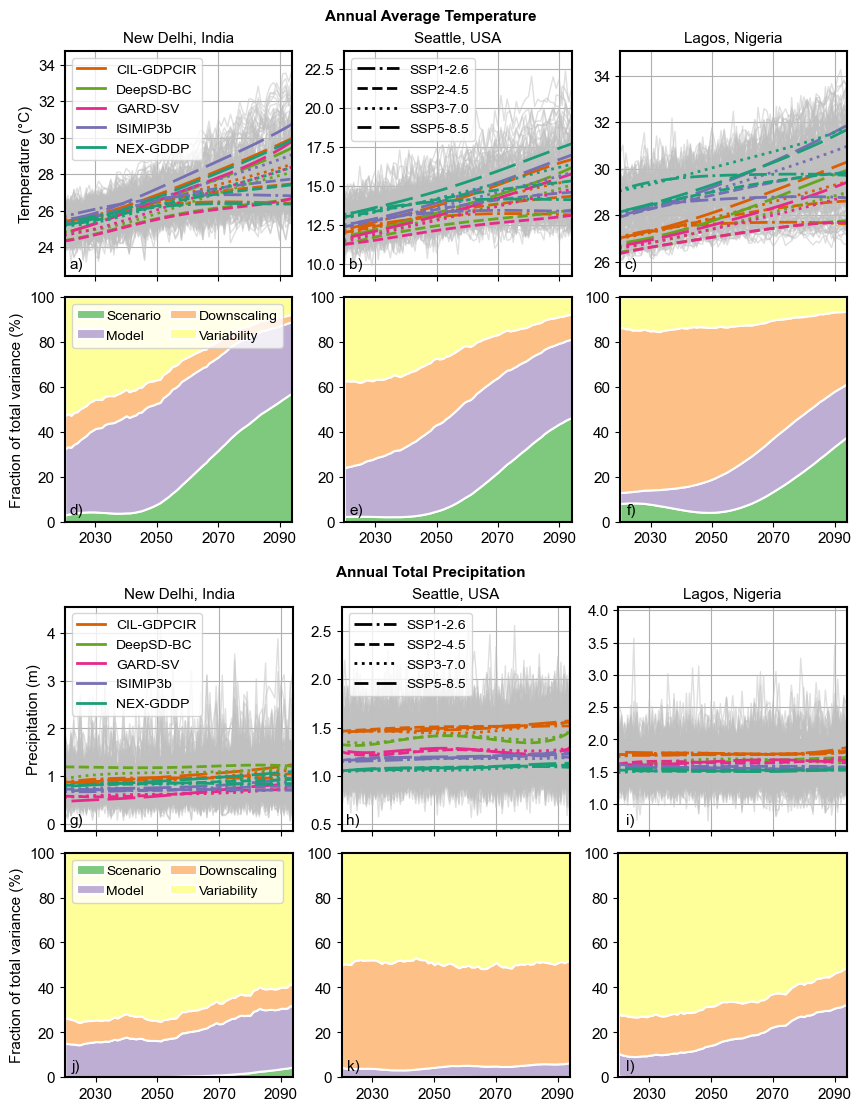

In [31]:
make_figure_1(
    cities=["delhi", "seattle", "lagos"],
    names=["New Delhi, India", "Seattle, USA", "Lagos, Nigeria"],
    metrics=["avg", "avg"],
    var_ids=["tas", "pr"],
    scenario_id="hs09",
    const_iav=False,
    titles=["Annual Average Temperature", "Annual Total Precipitation"],
    ylabels=["Temperature " + "(\N{DEGREE SIGN}C)", "Precipitation (m)"],
    deg=4,
    fig_label=True,
    savestr="Figure1",
)

# Figure 2

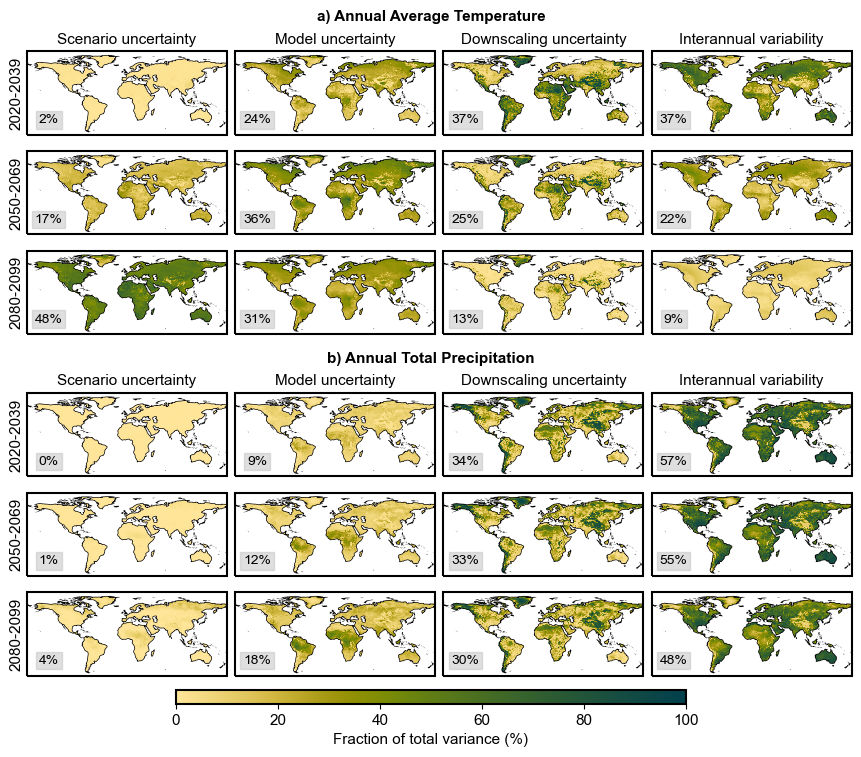

In [22]:
#################
#################
# Figure 2
plt.rcParams["font.size"] = 11
fs = 11
deg = 4
scenario_id = "hs09"

#################
#################
fig = plt.figure(figsize=(8.5, 7), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20, 20, 1])

############################
# Annual average tas
############################
axs = subfigs[0].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0].suptitle("a) Annual Average Temperature", fontweight="bold", fontsize=fs)

metric = "avg"
var_id = "tas"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id=scenario_id,
    axs=axs,
    fig=subfigs[0],
    cbar=False,
    title=False,
    fs=fs,
)

############################
# Annual average pr
############################
axs = subfigs[1].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1].suptitle("b) Annual Total Precipitation", fontweight="bold", fontsize=fs)

metric = "avg"
var_id = "pr"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id=scenario_id,
    axs=axs,
    fig=subfigs[1],
    cbar=False,
    title=False,
    fs=fs,
)

################
# Colorbar
################
cmap = bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(
    sm, cax=cbar_ax, orientation="horizontal", label="Fraction of total variance (%)"
)

plt.savefig("../figs/Figure2.png", dpi=600, bbox_inches="tight")
# plt.show()

# Figure 3

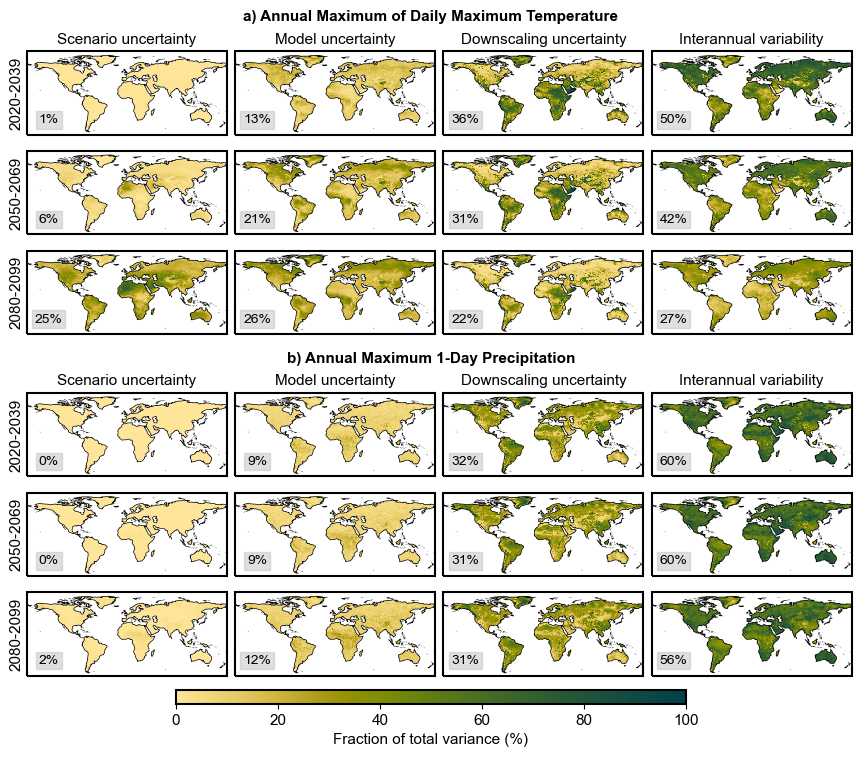

In [24]:
#################
#################
# Figure 3

plt.rcParams["font.size"] = 11
fs = 11
deg = 4
scenario_id = "hs09"

#################
#################
fig = plt.figure(figsize=(8.5, 7), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20, 20, 1])

############################
# Annual average tas
############################
axs = subfigs[0].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0].suptitle(
    "a) Annual Maximum of Daily Maximum Temperature", fontweight="bold", fontsize=fs
)

metric = "max"
var_id = "tasmax"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id=scenario_id,
    axs=axs,
    fig=subfigs[0],
    cbar=False,
    title=False,
    fs=fs,
)

############################
# Annual average pr
############################
axs = subfigs[1].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1].suptitle(
    "b) Annual Maximum 1-Day Precipitation", fontweight="bold", fontsize=fs
)

metric = "max"
var_id = "pr"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id=scenario_id,
    axs=axs,
    fig=subfigs[1],
    cbar=False,
    title=False,
    fs=fs,
)

################
# Colorbar
################
cmap = bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(
    sm, cax=cbar_ax, orientation="horizontal", label="Fraction of total variance (%)"
)

plt.savefig("../figs/Figure3.png", dpi=600, bbox_inches="tight")
# plt.show()

# Figure 4

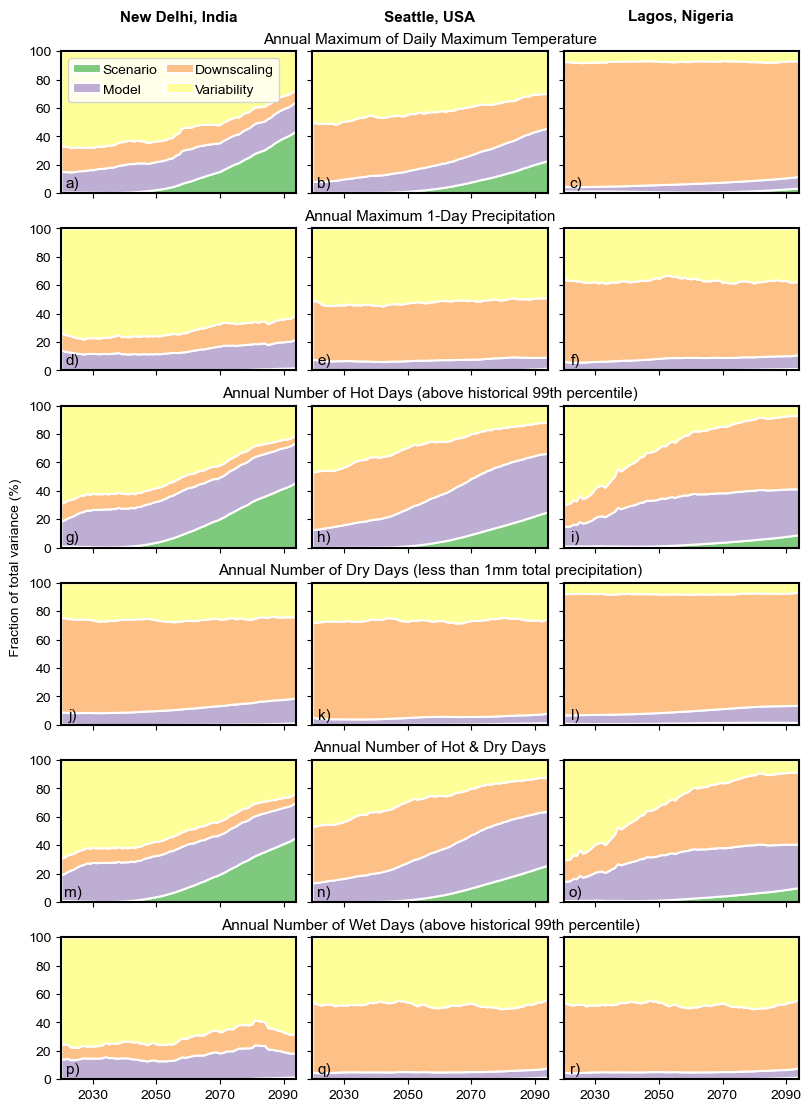

In [9]:
fig, axs = plt.subplots(
    nrows=7,
    ncols=3,
    figsize=(8, 11),
    constrained_layout=True,
    sharey=True,
    sharex=True,
    gridspec_kw={"height_ratios": [1, 10, 10, 10, 10, 10, 10]},
)

# Setup
plt.rcParams["font.size"] = 11
deg = 4
scenario_id = "hs09"
const_iav = False

# Cities
city1 = "delhi"
city2 = "seattle"
city3 = "lagos"

# Labels
left, width = 0.25, 0.5
bottom, height = 0.25, 0.5
right = left + width
top = bottom + height

axs[0, 0].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="New Delhi, India",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[0, 0].axis("off")

axs[0, 1].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Seattle, USA",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[0, 1].axis("off")

axs[0, 2].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Lagos, Nigeria",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[0, 2].axis("off")

# Tasmax maxima
plot_uc_timeseries(
    metric="max",
    var_id="tasmax",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=True,
    fig_label="a)",
    fig_label_height=0.07,
    ax=axs[1, 0],
)
axs[1, 0].set_yticks([0, 20, 40, 60, 80, 100])
plot_uc_timeseries(
    metric="max",
    var_id="tasmax",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Maximum of Daily Maximum Temperature",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="b)",
    fig_label_height=0.07,
    ax=axs[1, 1],
)
plot_uc_timeseries(
    metric="max",
    var_id="tasmax",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="c)",
    fig_label_height=0.07,
    ax=axs[1, 2],
)

# Pr maxima
plot_uc_timeseries(
    metric="max",
    var_id="pr",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="d)",
    fig_label_height=0.07,
    ax=axs[2, 0],
)
axs[2, 0].set_yticks([0, 20, 40, 60, 80, 100])
plot_uc_timeseries(
    metric="max",
    var_id="pr",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Maximum 1-Day Precipitation",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="e)",
    fig_label_height=0.07,
    ax=axs[2, 1],
)
plot_uc_timeseries(
    metric="max",
    var_id="pr",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="f)",
    fig_label_height=0.07,
    ax=axs[2, 2],
)

# Hot days: count
plot_uc_timeseries(
    metric="hot",
    var_id="tasmax_q99gmfd_count",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="g)",
    fig_label_height=0.07,
    ax=axs[3, 0],
)
axs[3, 0].set_yticks([0, 20, 40, 60, 80, 100])
plot_uc_timeseries(
    metric="hot",
    var_id="tasmax_q99gmfd_count",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Number of Hot Days (above historical 99th percentile)",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="h)",
    fig_label_height=0.07,
    ax=axs[3, 1],
)
plot_uc_timeseries(
    metric="hot",
    var_id="tasmax_q99gmfd_count",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="i)",
    fig_label_height=0.07,
    ax=axs[3, 2],
)

# Dry days: count
plot_uc_timeseries(
    metric="dry",
    var_id="count_lt_1",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    ylabel="\t\t\t\t\t\t\t\t\t\t\t Fraction of total variance (%)".replace(
        "\t", "    "
    ),
    xlabel="",
    legend=False,
    fig_label="j)",
    fig_label_height=0.07,
    ax=axs[4, 0],
)
plot_uc_timeseries(
    metric="dry",
    var_id="count_lt_1",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Number of Dry Days (less than 1mm total precipitation)",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="k)",
    fig_label_height=0.07,
    ax=axs[4, 1],
)
plot_uc_timeseries(
    metric="dry",
    var_id="count_lt_1",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="l)",
    fig_label_height=0.07,
    ax=axs[4, 2],
)

# Hot & Dry days: count
plot_uc_timeseries(
    metric="hotdry",
    var_id="hotdry_q99gmfd_count",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="m)",
    fig_label_height=0.07,
    ax=axs[5, 0],
)
plot_uc_timeseries(
    metric="hotdry",
    var_id="hotdry_q99gmfd_count",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Number of Hot & Dry Days",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="n)",
    fig_label_height=0.07,
    ax=axs[5, 1],
)
plot_uc_timeseries(
    metric="hotdry",
    var_id="hotdry_q99gmfd_count",
    region=city_list[city3],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="o)",
    fig_label_height=0.07,
    ax=axs[5, 2],
)

# Wet days: count
plot_uc_timeseries(
    metric="wet",
    var_id="pr_q99gmfd_count",
    region=city_list[city1],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="p)",
    fig_label_height=0.07,
    ax=axs[6, 0],
)
plot_uc_timeseries(
    metric="wet",
    var_id="pr_q99gmfd_count",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="Annual Number of Wet Days (above historical 99th percentile)",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="q)",
    fig_label_height=0.07,
    ax=axs[6, 1],
)
plot_uc_timeseries(
    metric="wet",
    var_id="pr_q99gmfd_count",
    region=city_list[city2],
    deg=deg,
    scenario_id=scenario_id,
    const_iav=const_iav,
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    fig_label="r)",
    fig_label_height=0.07,
    ax=axs[6, 2],
)

plt.savefig("../figs/Figure4.png", dpi=600)

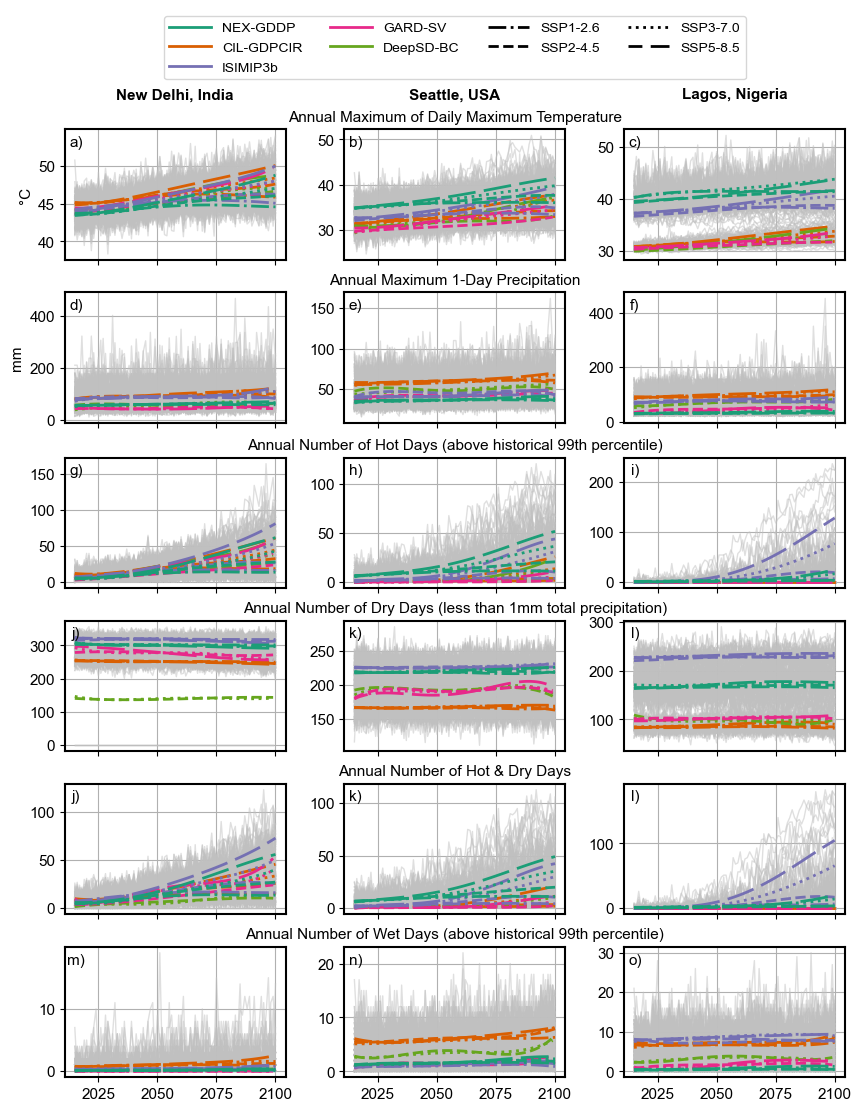

In [11]:
##############################
# Corresponding timeseries
# plot for SI
##############################


########## Function definition (similar to for figure 1)
def plot_timeseries(
    df,
    df_forced,
    metric,
    var_id,
    title,
    ylabel,
    xlabel,
    fig_label,
    ax,
):
    color_dict = {
        "NEX": "#1b9e77",
        "CIL": "#d95f02",
        "ISIMIP": "#7570b3",
        "GARD-SV": "#e7298a",
        "DeepSD-BC": "#66a61e",
    }
    line_dict = {
        "ssp585": (5, (10, 3)),
        "ssp370": "dotted",
        "ssp245": "dashed",
        "ssp126": "dashdot",
    }

    # Raw timeseries
    df_copy = df.set_index(["ensemble", "model", "ssp", "time"]).sort_index()
    for ensemble in df_copy.index.unique(level="ensemble"):
        for model in df_copy.loc[ensemble].index.unique(level="model"):
            for ssp in df_copy.loc[ensemble, model].index.unique(level="ssp"):
                ax.plot(
                    df_copy.loc[ensemble, model, ssp].index,
                    df_copy.loc[ensemble, model, ssp][var_id],
                    alpha=0.5,
                    color="silver",
                    lw=1,
                    label=None,
                )

    # Ensemble-SSP means
    df_mean = df_forced.groupby(["ensemble", "ssp", "time"]).mean(numeric_only=True)
    df_count = (
        df_forced[df_forced.time == 2050]
        .drop(columns="time")
        .groupby(["ensemble", "ssp"])
        .count()
    )

    for ensemble in df_mean.index.unique(level="ensemble"):
        for ssp in df_mean.loc[ensemble].index.unique(level="ssp"):
            if df_count.loc[ensemble, ssp][var_id] >= 2:
                ax.plot(
                    df_mean.loc[ensemble, ssp].index,
                    df_mean.loc[ensemble, ssp][var_id],
                    alpha=1,
                    color=color_dict[ensemble],
                    ls=line_dict[ssp],
                    lw=2,
                    label=None,
                )

    # Figure settings
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid()
    ax.set_title(title, fontsize=11)

    if fig_label:
        ax.text(
            0.05,
            0.90,
            fig_label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )


##################### Make plot
fig, axs = plt.subplots(
    nrows=8,
    ncols=3,
    figsize=(8.5, 11),
    constrained_layout=True,
    sharey=False,
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1, 10, 10, 10, 10, 10, 10]},
)

# Setup
plt.rcParams["font.size"] = 11
deg = 4
scenario_id = "hs09"
const_iav = False

# Cities
city1 = "delhi"
city2 = "seattle"
city3 = "lagos"

# Legend
axs[0, 0].remove()
axs[0, 1].remove()
axs[0, 2].remove()

gs = axs[0, 2].get_gridspec()
axlong = fig.add_subplot(gs[0, :])
axlong.axis("off")

color_dict = {
    "NEX": "#1b9e77",
    "CIL": "#d95f02",
    "ISIMIP": "#7570b3",
    "GARD-SV": "#e7298a",
    "DeepSD-BC": "#66a61e",
}

line_dict = {
    "ssp585": (5, (10, 3)),
    "ssp370": "dotted",
    "ssp245": "dashed",
    "ssp126": "dashdot",
}

custom_lines = [
    Line2D([0], [0], color=color_dict["NEX"], lw=2),
    Line2D([0], [0], color=color_dict["CIL"], lw=2),
    Line2D([0], [0], color=color_dict["ISIMIP"], lw=2),
    Line2D([0], [0], color=color_dict["GARD-SV"], lw=2),
    Line2D([0], [0], color=color_dict["DeepSD-BC"], lw=2),
    Line2D([0], [0], color="black", lw=2, ls=line_dict["ssp126"]),
    Line2D([0], [0], color="black", lw=2, ls=line_dict["ssp245"]),
    Line2D([0], [0], color="black", lw=2, ls=line_dict["ssp370"]),
    Line2D([0], [0], color="black", lw=2, ls=line_dict["ssp585"]),
]

axlong.legend(
    custom_lines,
    [
        "NEX-GDDP",
        "CIL-GDPCIR",
        "ISIMIP3b",
        "GARD-SV",
        "DeepSD-BC",
        "SSP1-2.6",
        "SSP2-4.5",
        "SSP3-7.0",
        "SSP5-8.5",
    ],
    ncol=4,
    loc="upper center",
    handlelength=3,
    fontsize=10,
)

# Labels
left, width = 0.25, 0.5
bottom, height = 0.25, 0.5
right = left + width
top = bottom + height

axs[1, 0].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="New Delhi, India",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[1, 0].axis("off")

axs[1, 1].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Seattle, USA",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[1, 1].axis("off")

axs[1, 2].text(
    x=0.5 * (left + right),
    y=0.5 * (bottom + top),
    s="Lagos, Nigeria",
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontweight="bold",
    fontsize=11,
)
axs[1, 2].axis("off")

############################
# Metric 1
############################
metric = "max"
var_id = "tasmax"

### City 1
city = city1
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[2, 0]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="\N{DEGREE SIGN}C",
    xlabel="",
    fig_label="a)",
    ax=ax,
)

### City 2
city = city2
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[2, 1]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="Annual Maximum of Daily Maximum Temperature",
    ylabel="",
    xlabel="",
    fig_label="b)",
    ax=ax,
)

### City 3
city = city3
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[2, 2]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="c)",
    ax=ax,
)

############################
# Metric 2
############################
metric = "max"
var_id = "pr"

### City 1
city = city1
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[3, 0]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="mm",
    xlabel="",
    fig_label="d)",
    ax=ax,
)

### City 2
city = city2
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[3, 1]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="Annual Maximum 1-Day Precipitation",
    ylabel="",
    xlabel="",
    fig_label="e)",
    ax=ax,
)

### City 3
city = city3
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[3, 2]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="f)",
    ax=ax,
)

############################
# Metric 3
############################
metric = "hot"
var_id = "tasmax_q99gmfd_count"

### City 1
city = city1
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[4, 0]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="g)",
    ax=ax,
)

### City 2
city = city2
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[4, 1]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="Annual Number of Hot Days (above historical 99th percentile)",
    ylabel="",
    xlabel="",
    fig_label="h)",
    ax=ax,
)

### City 3
city = city3
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[4, 2]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="i)",
    ax=ax,
)

############################
# Metric 4
############################
metric = "dry"
var_id = "count_lt_1"

### City 1
city = city1
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[5, 0]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="j)",
    ax=ax,
)

### City 2
city = city2
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[5, 1]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="Annual Number of Dry Days (less than 1mm total precipitation)",
    ylabel="",
    xlabel="",
    fig_label="k)",
    ax=ax,
)

### City 3
city = city3
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[5, 2]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="l)",
    ax=ax,
)

############################
# Metric 4
############################
metric = "hotdry"
var_id = "hotdry_q99gmfd_count"

### City 1
city = city1
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[6, 0]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="j)",
    ax=ax,
)

### City 2
city = city2
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[6, 1]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="Annual Number of Hot & Dry Days",
    ylabel="",
    xlabel="",
    fig_label="k)",
    ax=ax,
)

### City 3
city = city3
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[6, 2]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="l)",
    ax=ax,
)

###########################
# Metric 5
############################
metric = "wet"
var_id = "pr_q99gmfd_count"

### City 1
city = city1
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[7, 0]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="m)",
    ax=ax,
)

### City 2
city = city2
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[7, 1]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="Annual Number of Wet Days (above historical 99th percentile)",
    ylabel="",
    xlabel="",
    fig_label="n)",
    ax=ax,
)

### City 3
city = city3
lat, lon = city_list[city]

df = pd.read_csv(data_path + city + "_" + metric + "_" + var_id + ".csv")
df_forced = pd.read_csv(
    data_path + city + "_" + metric + "_" + var_id + "_forced_deg" + str(deg) + ".csv"
)

## Timeseries
ax = axs[7, 2]
plot_timeseries(
    df=df,
    df_forced=df_forced,
    metric=metric,
    var_id=var_id,
    title="",
    ylabel="",
    xlabel="",
    fig_label="o)",
    ax=ax,
)

plt.savefig("../figs/SIfig_extremes_timeseries.png", dpi=600)

# Figure 5

In [26]:
def make_figure_5(df, timeperiod, var_id, xlabel, ylabel, ens_legend, ssp_legend, fig):
    axs = fig.subplots(
        2,
        1,
        sharex=True,
        gridspec_kw={"hspace": 0.0, "wspace": 0.1, "height_ratios": [2.5, 1]},
    )

    # Drop ensembles
    df = df[~df.ensemble.isin(["DeepSD-BC", "GARD-SV"])]

    # Select time period
    if timeperiod == "mid":
        df_plot = df.query("time >= 2050 and time <= 2069")
    elif timeperiod == "late":
        df_plot = df.query("time >= 2070 and time <= 2099")

    # Plot aesthetics
    ens_color_dict = {
        "NEX": "#1b9e77",
        "CIL": "#d95f02",
        "ISIMIP": "#7570b3",
    }  # , 'GARD-SV':'#e7298a', 'DeepSD-BC':'#66a61e'}
    ens_label_dict = {"NEX": "NEX-GDDP", "CIL": "CIL-GDPCIR", "ISIMIP": "ISIMIP3b"}
    ssp_line_dict = {
        "ssp585": (5, (10, 3)),
        "ssp370": "dotted",
        "ssp245": "dashed",
        "ssp126": "dashdot",
    }
    ssp_label_dict = {
        "ssp585": "SSP5-8.5",
        "ssp370": "SSP3-7.0",
        "ssp245": "SSP2-4.5",
        "ssp126": "SSP1-2.6",
    }

    lw = 2
    boxw = 0.4  # boxplot width

    ssps = ssp_line_dict.keys()
    enss = ens_color_dict.keys()

    ################
    ## Boxplots
    ################
    ax = axs[1]

    # SSPs
    for idx, ssp in enumerate(ssps):
        boxplot = ax.boxplot(
            df_plot[df_plot.ssp == ssp][var_id].to_numpy(),
            vert=False,
            positions=[idx],
            patch_artist=True,
            medianprops=dict(linewidth=lw - 0.5, color="gray"),
            boxprops=dict(linewidth=lw - 0.5, color="gray"),
            whiskerprops=dict(linewidth=lw - 0.5, color="gray", ls=ssp_line_dict[ssp]),
            capprops=dict(linewidth=lw - 0.5, color="gray"),
            whis=(0.5, 99.5),
            showfliers=False,
            widths=boxw,
        )

        for patch in boxplot["boxes"]:
            patch.set_facecolor("white")

    # Ensembles
    for idx, ens in enumerate(enss):
        boxplot = ax.boxplot(
            df_plot[df_plot.ensemble == ens][var_id].to_numpy(),
            vert=False,
            positions=[len(ssp_line_dict.keys()) + idx],
            patch_artist=True,
            medianprops=dict(linewidth=lw - 0.5, color="black"),
            boxprops=dict(linewidth=lw - 0.5, color=ens_color_dict[ens]),
            whiskerprops=dict(linewidth=lw - 0.5, color=ens_color_dict[ens]),
            capprops=dict(linewidth=lw - 0.5, color=ens_color_dict[ens]),
            whis=(0.5, 99.5),
            showfliers=False,
            widths=boxw,
        )

        for patch in boxplot["boxes"]:
            patch.set_facecolor(ens_color_dict[ens])

    # Full
    # boxplot = ax.boxplot(df_plot[var_id].to_numpy(),
    #                      vert=False, positions=[len(ssp_line_dict.keys()) + len(ens_color_dict.keys())],
    #                      patch_artist=True,
    #                      medianprops=dict(linewidth=lw-0.5, color='white'),
    #                      boxprops=dict(linewidth=lw-0.5, color='black'),
    #                      whiskerprops=dict(linewidth=lw-0.5, color='black'),
    #                      capprops=dict(linewidth=lw-0.5, color='black'),
    #                      whis=(0.5,99.5),
    #                      showfliers=False,
    #                      widths=boxw)

    # for patch in boxplot['boxes']:
    #     patch.set_facecolor('black')

    # Axes
    ax.set_xlabel(xlabel)
    ax.set_xlim(ax.get_xlim())
    ax.set_yticklabels("")
    ax.set_yticks([])
    ax.spines[["right", "top", "left"]].set_visible(False)

    #################
    ### KDE plots
    #################
    ax = axs[0]

    # SSPs
    for ssp in ssps:
        df_plot[df_plot.ssp == ssp][var_id].plot.kde(
            ax=ax, color="gray", ls=ssp_line_dict[ssp], lw=lw
        )
    # Ensembles
    for ens in enss:
        df_plot[df_plot.ensemble == ens][var_id].plot.kde(
            ax=ax, color=ens_color_dict[ens], lw=lw
        )

    # Full
    # df_plot[var_id].plot.kde(ax=ax,
    #                          color='black',
    #                          lw=lw+1)

    if ens_legend:
        custom_lines = [Line2D([0], [0], color="black", lw=lw + 1)] + [
            Line2D([0], [0], color=ens_color_dict[ens], lw=lw)
            for ens in list(enss)[::-1]
        ]
        ax.legend(
            custom_lines,
            ["Full Ensemble"] + [ens_label_dict[ens] for ens in list(enss)[::-1]],
            handlelength=2,
        )
    if ssp_legend:
        custom_lines = [
            Line2D([0], [0], color="gray", lw=lw, ls=ssp_line_dict[ssp])
            for ssp in list(ssps)[::-1]
        ]
        ax.legend(
            custom_lines,
            [ssp_label_dict[ssp] for ssp in list(ssps)[::-1]],
            handlelength=3,
        )

    # ax.grid(alpha=0.5)
    ax.set_ylabel(ylabel)
    ax.set_yticklabels("")
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.tick_params(axis="y", which="both", bottom=False, left=False)
    ax.spines[["right", "top"]].set_visible(False)
    if var_id[:3] == "pr_" or var_id[:7] == "tasmax_":
        ax.set_xlim([0, ax.get_xlim()[1]])

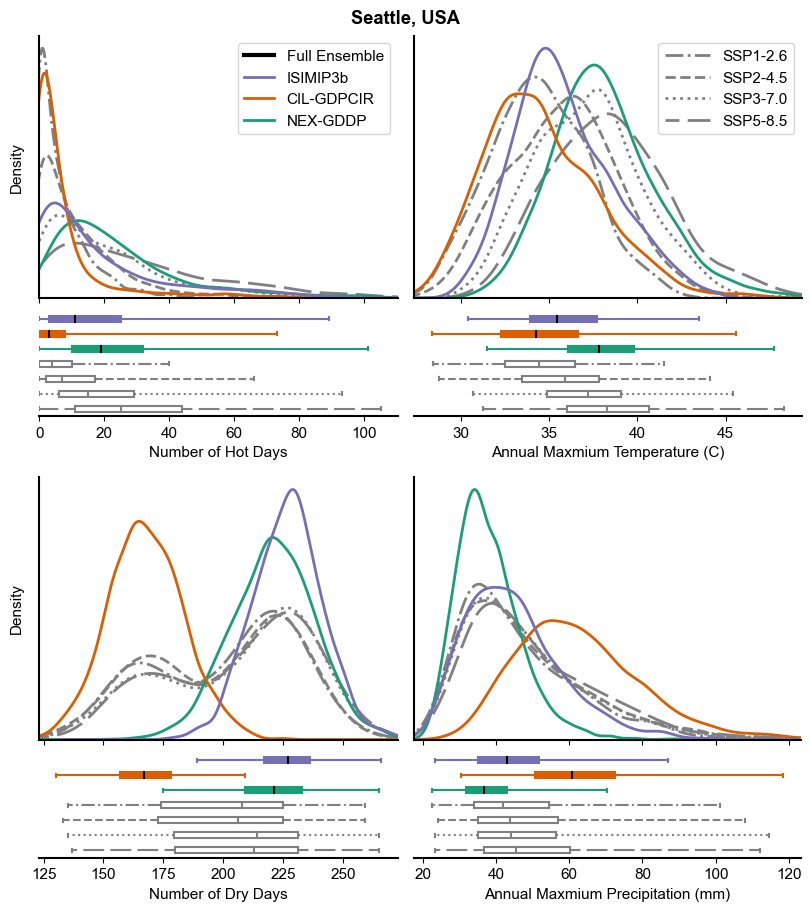

In [28]:
# Plot
plt.rcParams["font.size"] = 11

fig = plt.figure(figsize=(8, 9), constrained_layout=True)
subfigs = fig.subfigures(2, 2)

# Select city
city = "seattle"
fig.suptitle("Seattle, USA", fontweight="bold")

# Temperature
make_figure_5(
    pd.read_csv(data_path + city + "_hot_tasmax_q99gmfd_count.csv"),
    "late",
    "tasmax_q99gmfd_count",
    "Number of Hot Days",
    "Density",
    True,
    False,
    subfigs[0, 0],
)
# make_figure_5(pd.read_csv(data_path + city + '_avg_tas.csv'),
#               'late', 'tas', 'Annual Average Temperature (C)', 'Density', True, False, subfigs[0,0])
make_figure_5(
    pd.read_csv(data_path + city + "_max_tasmax.csv"),
    "late",
    "tasmax",
    "Annual Maxmium Temperature (C)",
    "",
    False,
    True,
    subfigs[0, 1],
)

# Precip
# make_figure_5(pd.read_csv(data_path + city + '_wet_pr_q99gmfd_count.csv'),
#               'late', 'pr_q99gmfd_count', 'Number of Wet Days', 'Density', False, False, subfigs[1,0])
make_figure_5(
    pd.read_csv(data_path + city + "_dry_count_lt_1.csv"),
    "late",
    "count_lt_1",
    "Number of Dry Days",
    "Density",
    False,
    False,
    subfigs[1, 0],
)
# make_figure_5(pd.read_csv(data_path + city + '_avg_pr.csv'),
#               'late', 'pr', 'Annual Total Precipitation (m)', 'Density', False, False, subfigs[1,0])
make_figure_5(
    pd.read_csv(data_path + city + "_max_pr.csv"),
    "late",
    "pr",
    "Annual Maxmium Precipitation (mm)",
    "",
    False,
    False,
    subfigs[1, 1],
)

plt.show()

In [32]:
def make_figure_5(df, timeperiod, var_id, xlabel, ylabel, ax):
    # Drop ensembles
    df = df[~df.ensemble.isin(["DeepSD-BC", "GARD-SV"])]

    # Select time period
    if timeperiod == "mid":
        df_plot = df.query("time >= 2050 and time <= 2069")
    elif timeperiod == "late":
        df_plot = df.query("time >= 2070 and time <= 2099")

    # Plot aesthetics
    ens_color_dict = {
        "NEX": "#1b9e77",
        "CIL": "#d95f02",
        "ISIMIP": "#7570b3",
    }  # , 'GARD-SV':'#e7298a', 'DeepSD-BC':'#66a61e'}
    ens_label_dict = {"NEX": "NEX-GDDP", "CIL": "CIL-GDPCIR", "ISIMIP": "ISIMIP3b"}
    # ssp_line_dict = {'ssp585':(5, (10, 3)), 'ssp370':'dotted', 'ssp245':'dashed', 'ssp126':'dashdot'}
    ssp_label_dict = {
        "ssp585": "SSP5-8.5",
        "ssp370": "SSP3-7.0",
        "ssp245": "SSP2-4.5",
        "ssp126": "SSP1-2.6",
    }

    lw = 2
    boxw = 0.4  # boxplot width

    ssps = ssp_label_dict.keys()
    enss = ens_label_dict.keys()

    ################
    ## Boxplots
    ################
    # SSPs
    for idx, ssp in enumerate(ssps):
        boxplot = ax.boxplot(
            df_plot[df_plot.ssp == ssp][var_id].to_numpy(),
            vert=False,
            positions=[idx],
            patch_artist=True,
            medianprops=dict(linewidth=lw - 0.5, color="gray"),
            boxprops=dict(linewidth=lw - 0.5, color="gray"),
            whiskerprops=dict(linewidth=lw - 0.5, color="gray"),
            capprops=dict(linewidth=lw - 0.5, color="gray"),
            whis=(0.5, 99.5),
            showfliers=False,
            widths=boxw,
        )

        for patch in boxplot["boxes"]:
            patch.set_facecolor("white")

    # Ensembles
    for idx, ens in enumerate(enss):
        boxplot = ax.boxplot(
            df_plot[df_plot.ensemble == ens][var_id].to_numpy(),
            vert=False,
            positions=[len(ssp_label_dict.keys()) + idx],
            patch_artist=True,
            medianprops=dict(linewidth=lw - 0.5, color="black"),
            boxprops=dict(linewidth=lw - 0.5, color=ens_color_dict[ens]),
            whiskerprops=dict(linewidth=lw - 0.5, color=ens_color_dict[ens]),
            capprops=dict(linewidth=lw - 0.5, color=ens_color_dict[ens]),
            whis=(0.5, 99.5),
            showfliers=False,
            widths=boxw,
        )

        for patch in boxplot["boxes"]:
            patch.set_facecolor(ens_color_dict[ens])

    # Full
    boxplot = ax.boxplot(
        df_plot[var_id].to_numpy(),
        vert=False,
        positions=[len(ssp_label_dict.keys()) + len(ens_label_dict.keys())],
        patch_artist=True,
        medianprops=dict(linewidth=lw - 0.5, color="white"),
        boxprops=dict(linewidth=lw - 0.5, color="black"),
        whiskerprops=dict(linewidth=lw - 0.5, color="black"),
        capprops=dict(linewidth=lw - 0.5, color="black"),
        whis=(0.5, 99.5),
        showfliers=False,
        widths=boxw,
    )

    for patch in boxplot["boxes"]:
        patch.set_facecolor("black")

    # Axes
    ax.grid(axis="x", alpha=0.5)
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_yticklabels(
            [ssp_label_dict[ssp] for ssp in ssps]
            + [ens_label_dict[ens] for ens in enss]
            + ["Full Ensemble"]
        )
    else:
        ax.set_yticklabels("")
        ax.set_yticks([])

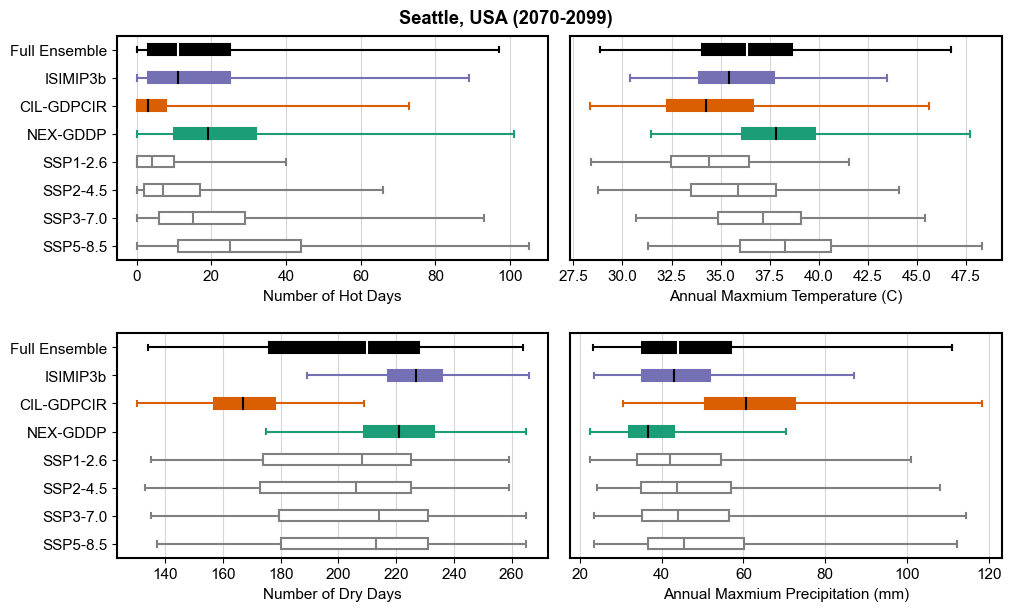

In [33]:
# Plot
plt.rcParams["font.size"] = 11

fig, axs = plt.subplots(
    2, 2, figsize=(10, 6), constrained_layout=True, gridspec_kw={"hspace": 0.1}
)

# Select city
city = "seattle"
fig.suptitle("Seattle, USA (2070-2099)", fontweight="bold")

# Temperature
make_figure_5(
    pd.read_csv(data_path + city + "_hot_tasmax_q99gmfd_count.csv"),
    "late",
    "tasmax_q99gmfd_count",
    "Number of Hot Days",
    True,
    axs[0, 0],
)
make_figure_5(
    pd.read_csv(data_path + city + "_max_tasmax.csv"),
    "late",
    "tasmax",
    "Annual Maxmium Temperature (C)",
    False,
    axs[0, 1],
)

# Precip
make_figure_5(
    pd.read_csv(data_path + city + "_dry_count_lt_1.csv"),
    "late",
    "count_lt_1",
    "Number of Dry Days",
    True,
    axs[1, 0],
)
make_figure_5(
    pd.read_csv(data_path + city + "_max_pr.csv"),
    "late",
    "pr",
    "Annual Maxmium Precipitation (mm)",
    False,
    axs[1, 1],
)

plt.savefig("../figs/Figure5.png", dpi=600)

# Other metrics: map plots

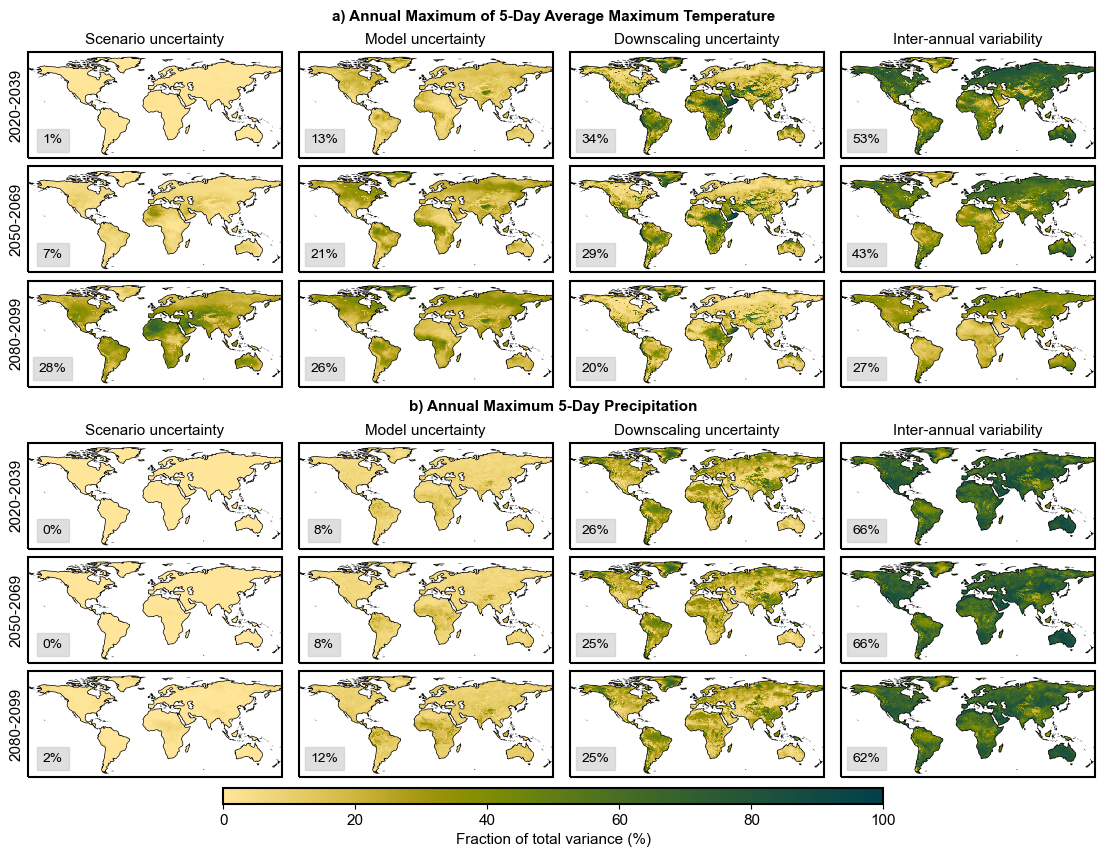

In [29]:
#################
#################
plt.rcParams["font.size"] = 11
deg = 4

#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20, 20, 1])

############################
# Annual average tas
############################
axs = subfigs[0].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0].suptitle(
    "a) Annual Maximum of 5-Day Average Maximum Temperature",
    fontweight="bold",
    fontsize=11,
)

metric = "max5d"
var_id = "tasmax"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[0],
    cbar=False,
    title=False,
)

############################
# Annual average pr
############################
axs = subfigs[1].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1].suptitle(
    "b) Annual Maximum 5-Day Precipitation", fontweight="bold", fontsize=11
)

metric = "max5d"
var_id = "RX5day"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[1],
    cbar=False,
    title=False,
)

################
# Colorbar
################
cmap = bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(
    sm, cax=cbar_ax, orientation="horizontal", label="Fraction of total variance (%)"
)

plt.savefig("../figs/UC_max5d.png", dpi=600, bbox_inches="tight")
# plt.show()

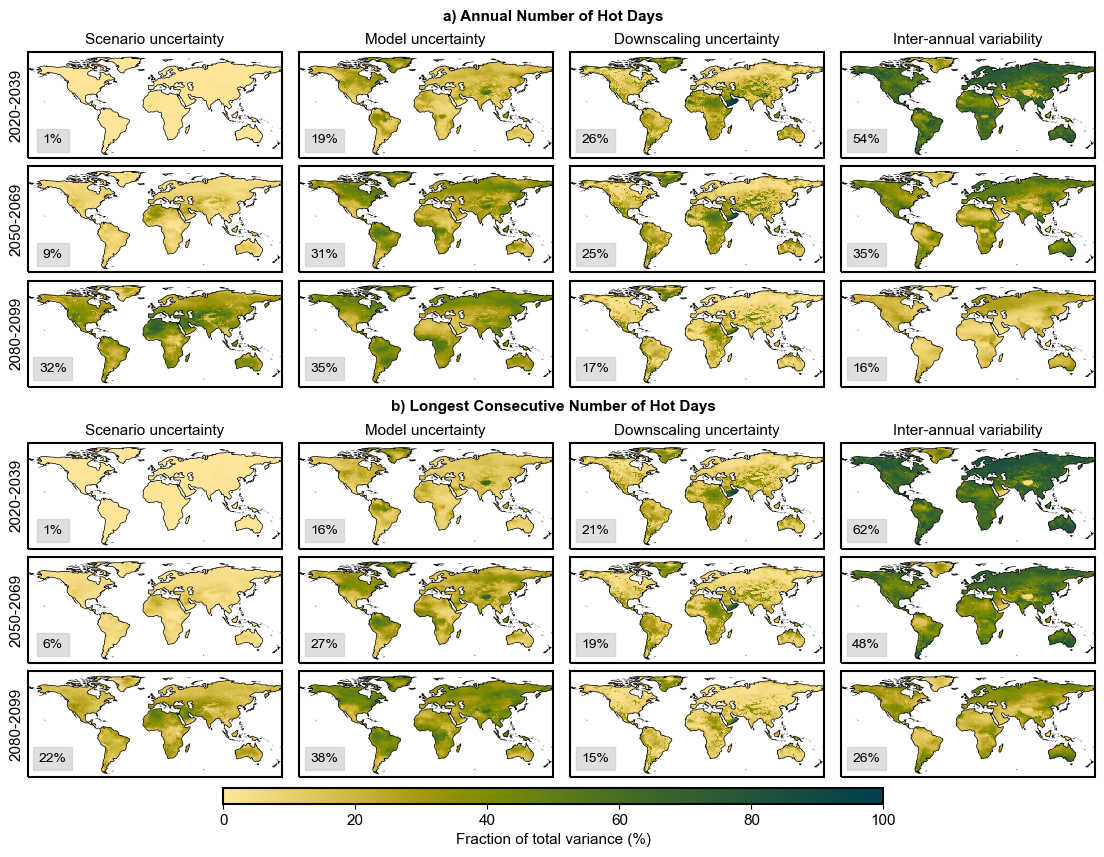

In [30]:
#################
#################
plt.rcParams["font.size"] = 11
deg = 4
#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20, 20, 1])

axs = subfigs[0].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0].suptitle("a) Annual Number of Hot Days", fontweight="bold", fontsize=11)

metric = "hot"
var_id = "tasmax_q99gmfd_count"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[0],
    cbar=False,
    title=False,
)

axs = subfigs[1].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1].suptitle(
    "b) Longest Consecutive Number of Hot Days", fontweight="bold", fontsize=11
)

metric = "hot"
var_id = "tasmax_q99gmfd_streak"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[1],
    cbar=False,
    title=False,
)

################
# Colorbar
################
cmap = bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(
    sm, cax=cbar_ax, orientation="horizontal", label="Fraction of total variance (%)"
)

plt.savefig("../figs/UC_hot_days.png", dpi=600, bbox_inches="tight")
# plt.show()

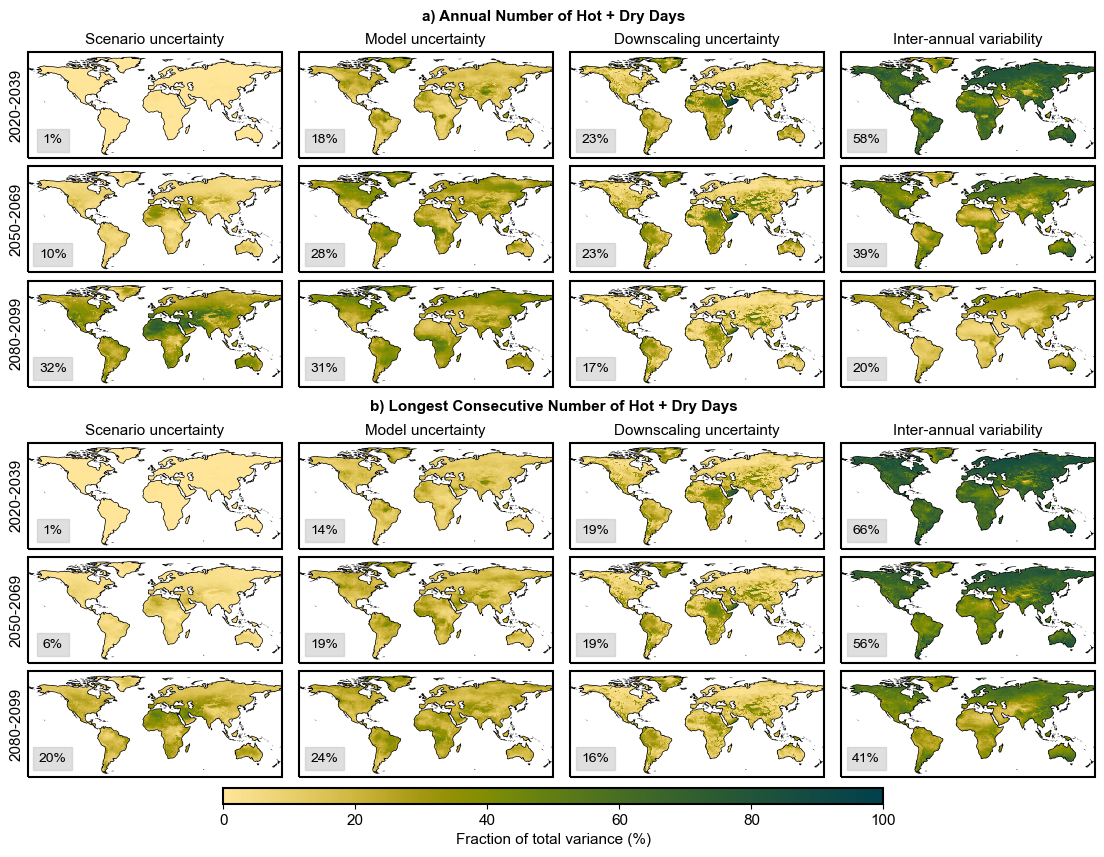

In [31]:
#################
#################
# Hot + Dry

plt.rcParams["font.size"] = 11
deg = 4

#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20, 20, 1])

axs = subfigs[0].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0].suptitle(
    "a) Annual Number of Hot + Dry Days", fontweight="bold", fontsize=11
)

metric = "hotdry"
var_id = "hotdry_q99gmfd_count"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[0],
    cbar=False,
    title=False,
)

axs = subfigs[1].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1].suptitle(
    "b) Longest Consecutive Number of Hot + Dry Days", fontweight="bold", fontsize=11
)

metric = "hotdry"
var_id = "hotdry_q99gmfd_streak"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[1],
    cbar=False,
    title=False,
)

################
# Colorbar
################
cmap = bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(
    sm, cax=cbar_ax, orientation="horizontal", label="Fraction of total variance (%)"
)

plt.savefig("../figs/UC_hotdry_days.png", dpi=600, bbox_inches="tight")
# plt.show()

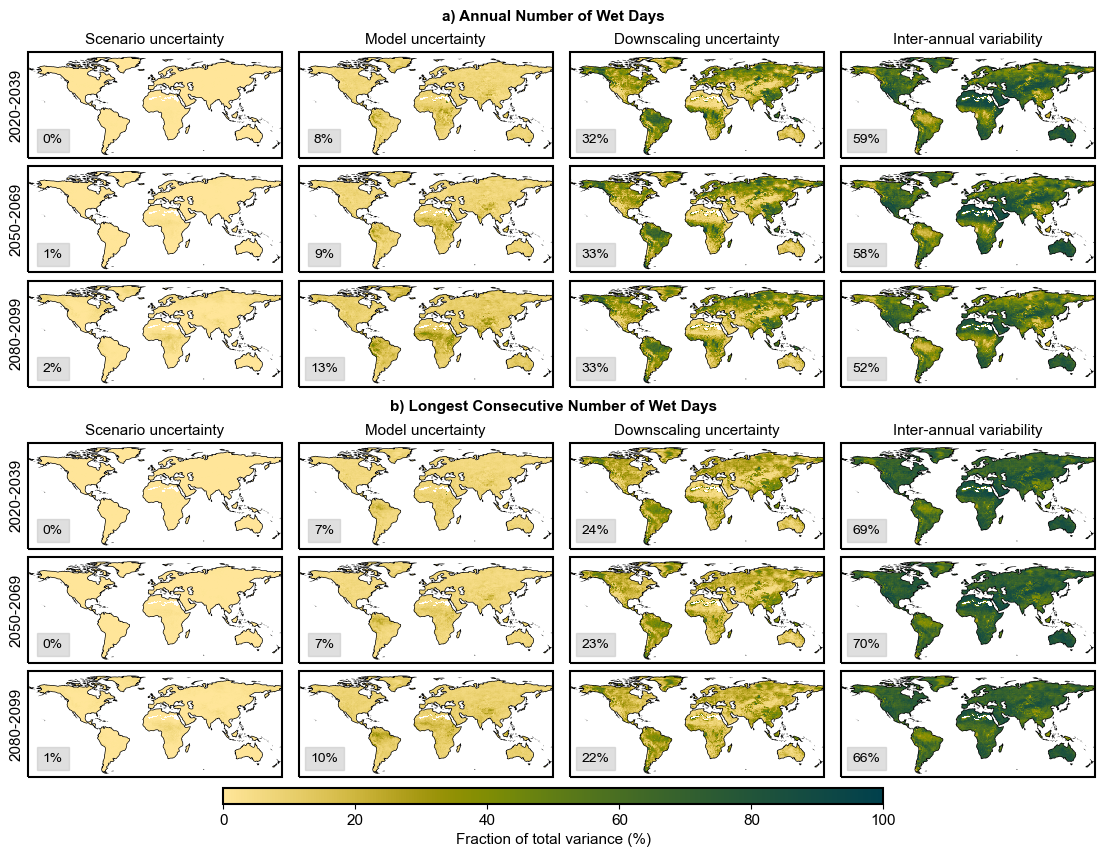

In [32]:
#################
#################
# Wet days

plt.rcParams["font.size"] = 11
deg = 4
#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20, 20, 1])

axs = subfigs[0].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0].suptitle("a) Annual Number of Wet Days", fontweight="bold", fontsize=11)

metric = "wet"
var_id = "pr_q99gmfd_count"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[0],
    cbar=False,
    title=False,
)

axs = subfigs[1].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1].suptitle(
    "b) Longest Consecutive Number of Wet Days", fontweight="bold", fontsize=11
)

metric = "wet"
var_id = "pr_q99gmfd_streak"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[1],
    cbar=False,
    title=False,
)

################
# Colorbar
################
cmap = bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(
    sm, cax=cbar_ax, orientation="horizontal", label="Fraction of total variance (%)"
)

plt.savefig("../figs/UC_wet_days.png", dpi=600, bbox_inches="tight")
plt.show()

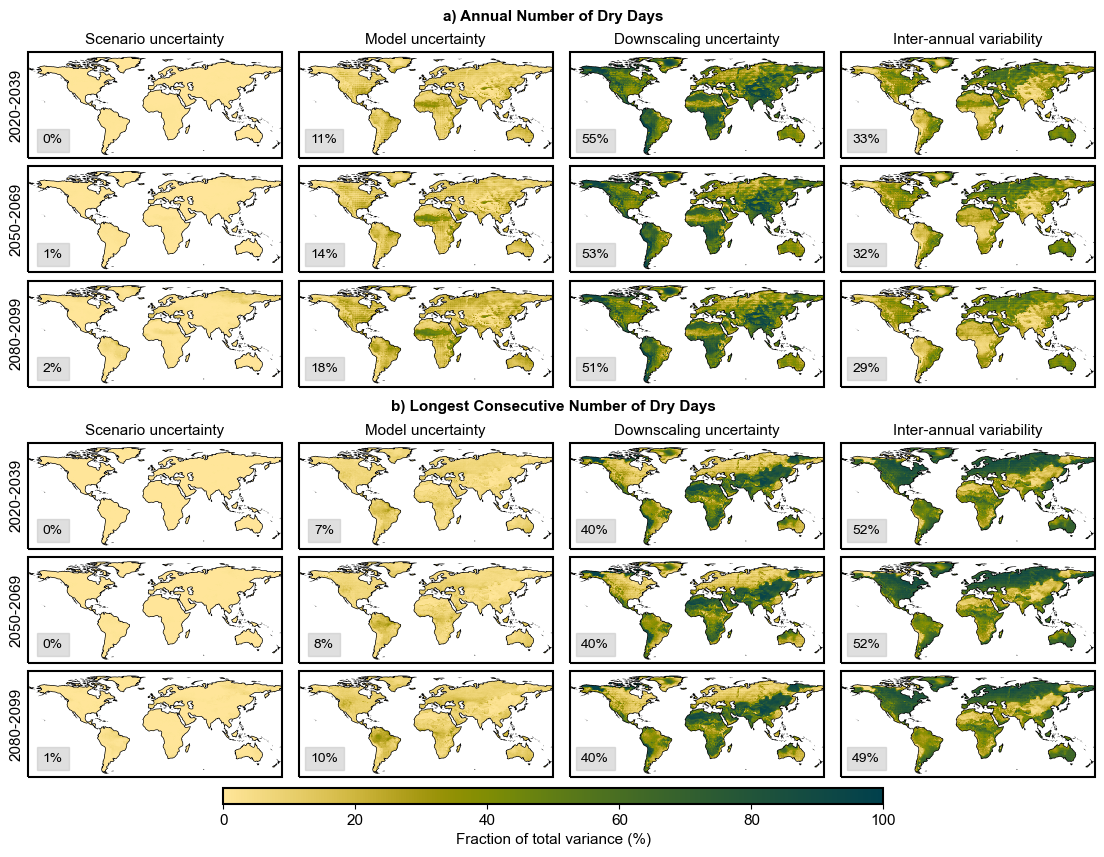

In [33]:
#################
#################
# Dry days

plt.rcParams["font.size"] = 11
deg = 4

#################
#################
fig = plt.figure(figsize=(11, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1, height_ratios=[20, 20, 1])

axs = subfigs[0].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[0].suptitle("a) Annual Number of Dry Days", fontweight="bold", fontsize=11)

metric = "dry"
var_id = "count_lt_1"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[0],
    cbar=False,
    title=False,
)

axs = subfigs[1].subplots(3, 4, subplot_kw={"projection": ccrs.PlateCarree()})
subfigs[1].suptitle(
    "b) Longest Consecutive Number of Dry Days", fontweight="bold", fontsize=11
)

metric = "dry"
var_id = "streak_lt_1"

plot_uc_map(
    metric=metric,
    var_id=var_id,
    const_iav=False,
    deg=deg,
    scenario_id="hs09",
    axs=axs,
    fig=subfigs[1],
    cbar=False,
    title=False,
)

################
# Colorbar
################
cmap = bamako_map
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar_ax = subfigs[2].add_axes([0.2, 0.1, 0.6, 0.8])
cbar = subfigs[2].colorbar(
    sm, cax=cbar_ax, orientation="horizontal", label="Fraction of total variance (%)"
)

plt.savefig("../figs/UC_dry_days.png", dpi=600, bbox_inches="tight")
# plt.show()

# Other metrics: regional plots

In [ ]:
##############################
# Regional UC timeseries
# (for hot_spatial)
##############################
def plot_uc_timeseries_region(
    metric,
    submetric,
    var_id,
    region,
    deg,
    scenario_id,
    title,
    ylabel,
    xlabel,
    legend,
    ax,
):
    """
    Region must be IPCC AR6 region name. IAV must be assumed constant.
    """
    # Setup read paths
    uc_read_path = (
        path_in
        + "uncertainty_partitioning/"
        + metric
        + "_"
        + submetric
        + "_deg"
        + str(deg)
        + "_noISIMIP.csv"
    )
    iav_read_path = (
        path_in
        + "uncertainty_partitioning/"
        + metric
        + "_"
        + submetric
        + "_deg"
        + str(deg)
        + "_const_iav_noISIMIP.csv"
    )

    # Read
    df_uc = pd.read_csv(uc_read_path)
    df_iav = pd.read_csv(iav_read_path)
    df_iav["uncertainty"] = "variability"

    # Select region
    df_uc_region = df_uc[df_uc.region == region]
    df_iav_region = df_iav[df_iav.region == region]

    # Add year index for IAV
    df_iav_region = pd.concat([df_iav_region] * 85)
    df_iav_region["year"] = np.arange(2015, 2100)

    # Merge
    df_region = pd.concat([df_iav_region, df_uc_region])

    # Select var_id
    df_region = df_region[["year", "uncertainty", var_id]]

    # Select correct uncertainties
    scenario = "scenario_" + scenario_id
    df_region = df_region[
        df_region.uncertainty.isin(["ensemble", "model", scenario, "variability"])
    ]

    # Get 'total' uncertainty
    U_total = df_region.groupby("year").sum(numeric_only=True).reset_index()

    # Model uncertainty
    U_model = df_region[df_region.uncertainty == "model"].drop(columns="uncertainty")
    U_model = pd.merge(U_model, U_total, on="year", suffixes=("_model", "_total"))
    U_model["U_model"] = 100 * U_model[var_id + "_model"] / U_model[var_id + "_total"]

    # Downscaling uncertainty
    U_ens = df_region[df_region.uncertainty == "ensemble"].drop(columns="uncertainty")
    U_ens = pd.merge(U_ens, U_total, on="year", suffixes=("_ensemble", "_total"))
    U_ens["U_ens"] = 100 * U_ens[var_id + "_ensemble"] / U_ens[var_id + "_total"]

    # Scenario uncertainty
    U_scen = df_region[df_region.uncertainty == scenario].drop(columns="uncertainty")
    U_scen = pd.merge(U_scen, U_total, on="year", suffixes=("_scen", "_total"))
    U_scen["U_scen"] = 100 * U_scen[var_id + "_scen"] / U_scen[var_id + "_total"]

    # Interannual variability
    U_iav = df_region[df_region.uncertainty == "variability"].drop(
        columns="uncertainty"
    )
    U_iav = pd.merge(U_iav, U_total, on="year", suffixes=("_iav", "_total"))
    U_iav["U_iav"] = 100 * U_iav[var_id + "_iav"] / U_iav[var_id + "_total"]

    # Construct plotting dict
    uncert_dict = {
        "Scenario": U_scen.sort_values(by="year")["U_scen"].to_numpy(),
        "Model": U_model.sort_values(by="year")["U_model"].to_numpy(),
        "Downscaling": U_ens.sort_values(by="year")["U_ens"].to_numpy(),
        "Variability": U_iav.sort_values(by="year")["U_iav"].to_numpy(),
    }

    # Make plot
    ax.stackplot(
        np.arange(2015, 2100),
        uncert_dict.values(),
        labels=uncert_dict.keys(),
        alpha=1,
        colors=["#7fc97f", "#beaed4", "#fdc086", "#ffff99"],
        edgecolor="white",
        lw=1.5,
    )

    if legend:
        ax.legend(
            loc="upper left", ncol=2, columnspacing=1, handletextpad=0.1, fontsize=10
        )
    ax.set_ylim([0, 100])
    ax.set_xlim([2015, 2099])
    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontsize=11)

In [23]:
# Plot IPCC AR6 regions
def plot_ar6_regions(regions, ax):
    text_kws = dict(color="#67000d", fontsize=10, bbox=dict(pad=0.2, color="w"))

    regionmask.defined_regions.ar6.land[regions].plot(
        text_kws=text_kws, add_ocean=True, label="abbrev", ax=ax
    )

    ax.add_feature(cfeature.BORDERS, edgecolor="gray")
    ax.set_extent([-150, -45, 5, 65])

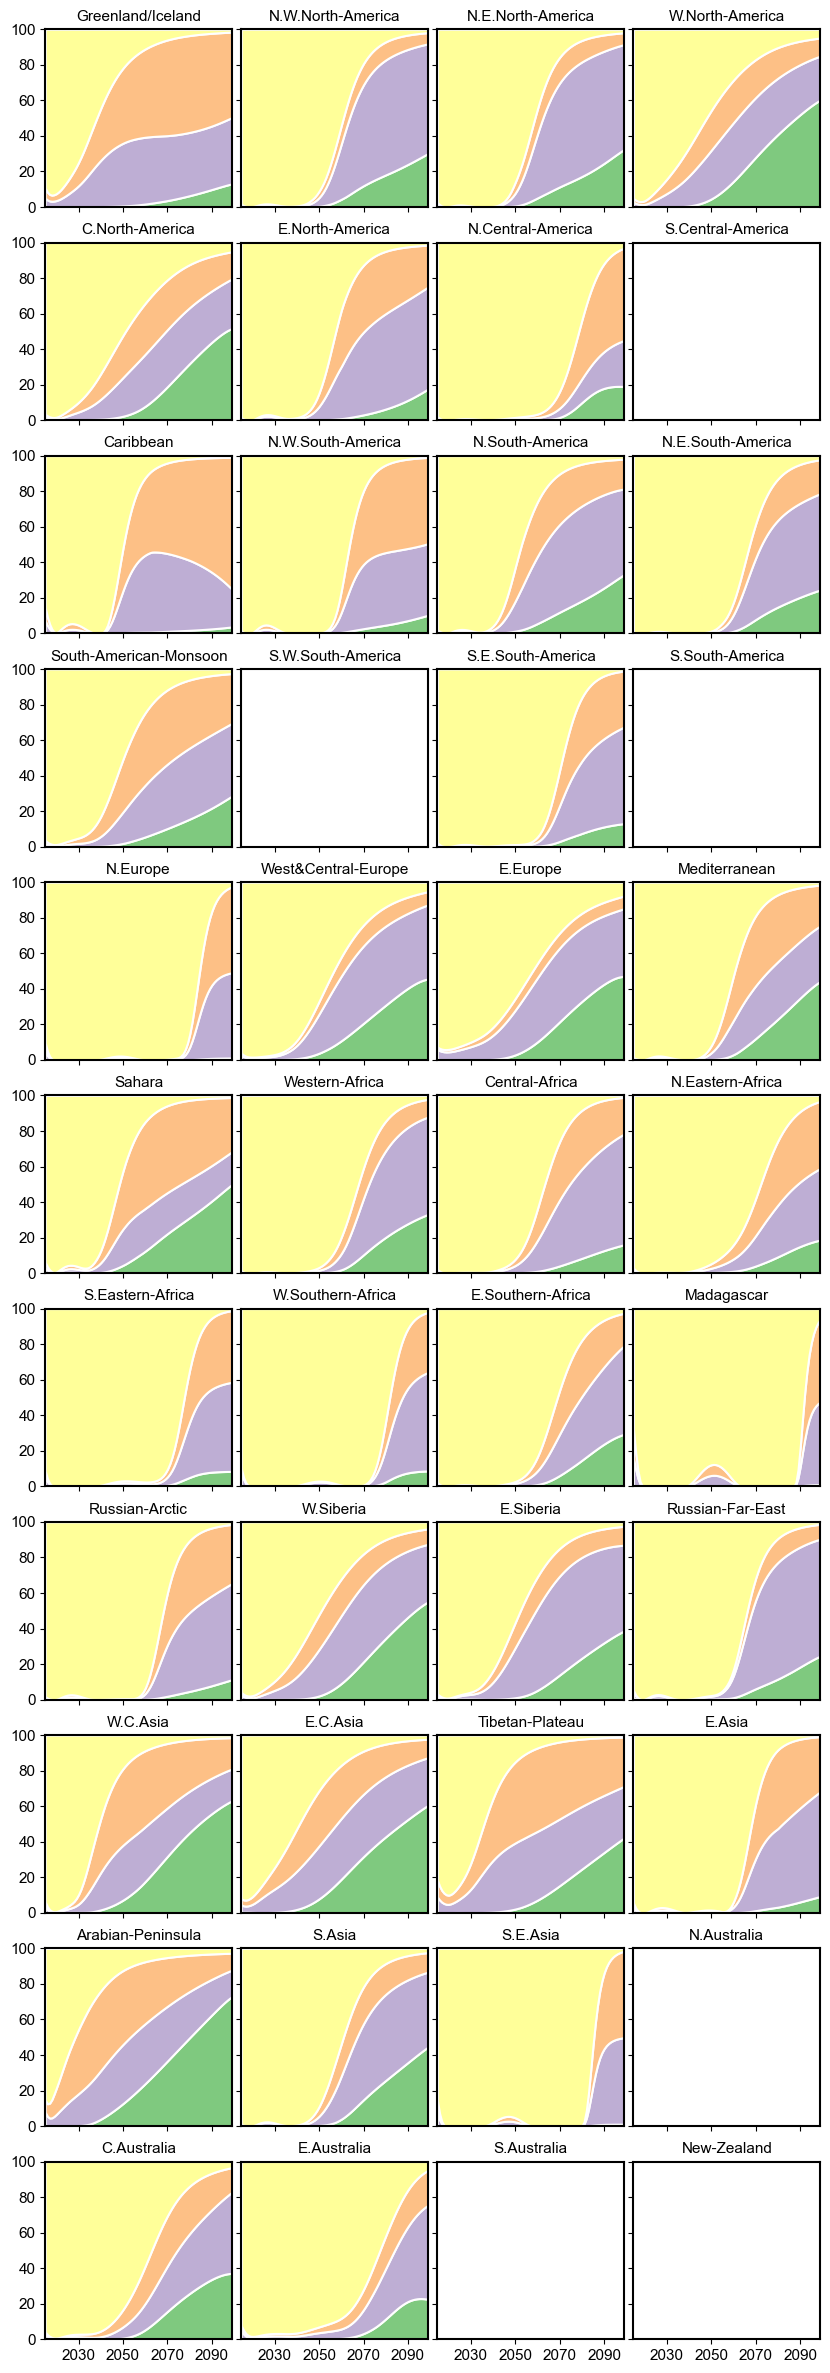

In [97]:
fig, axs = plt.subplots(
    11, 4, figsize=(10, 30), gridspec_kw={"wspace": 0.05}, sharex=True, sharey=True
)
axs = axs.flatten()

deg = 4

for i, region in enumerate(regionmask.defined_regions.ar6.land.abbrevs[:-2]):
    plot_uc_timeseries_region(
        "hot_spatial",
        "tasmax",
        "tasmax_q99gmfd_count",
        region,
        deg,
        "hs09",
        regionmask.defined_regions.ar6.land.names[i],
        "",
        "",
        False,
        axs[i],
    )

plt.show()

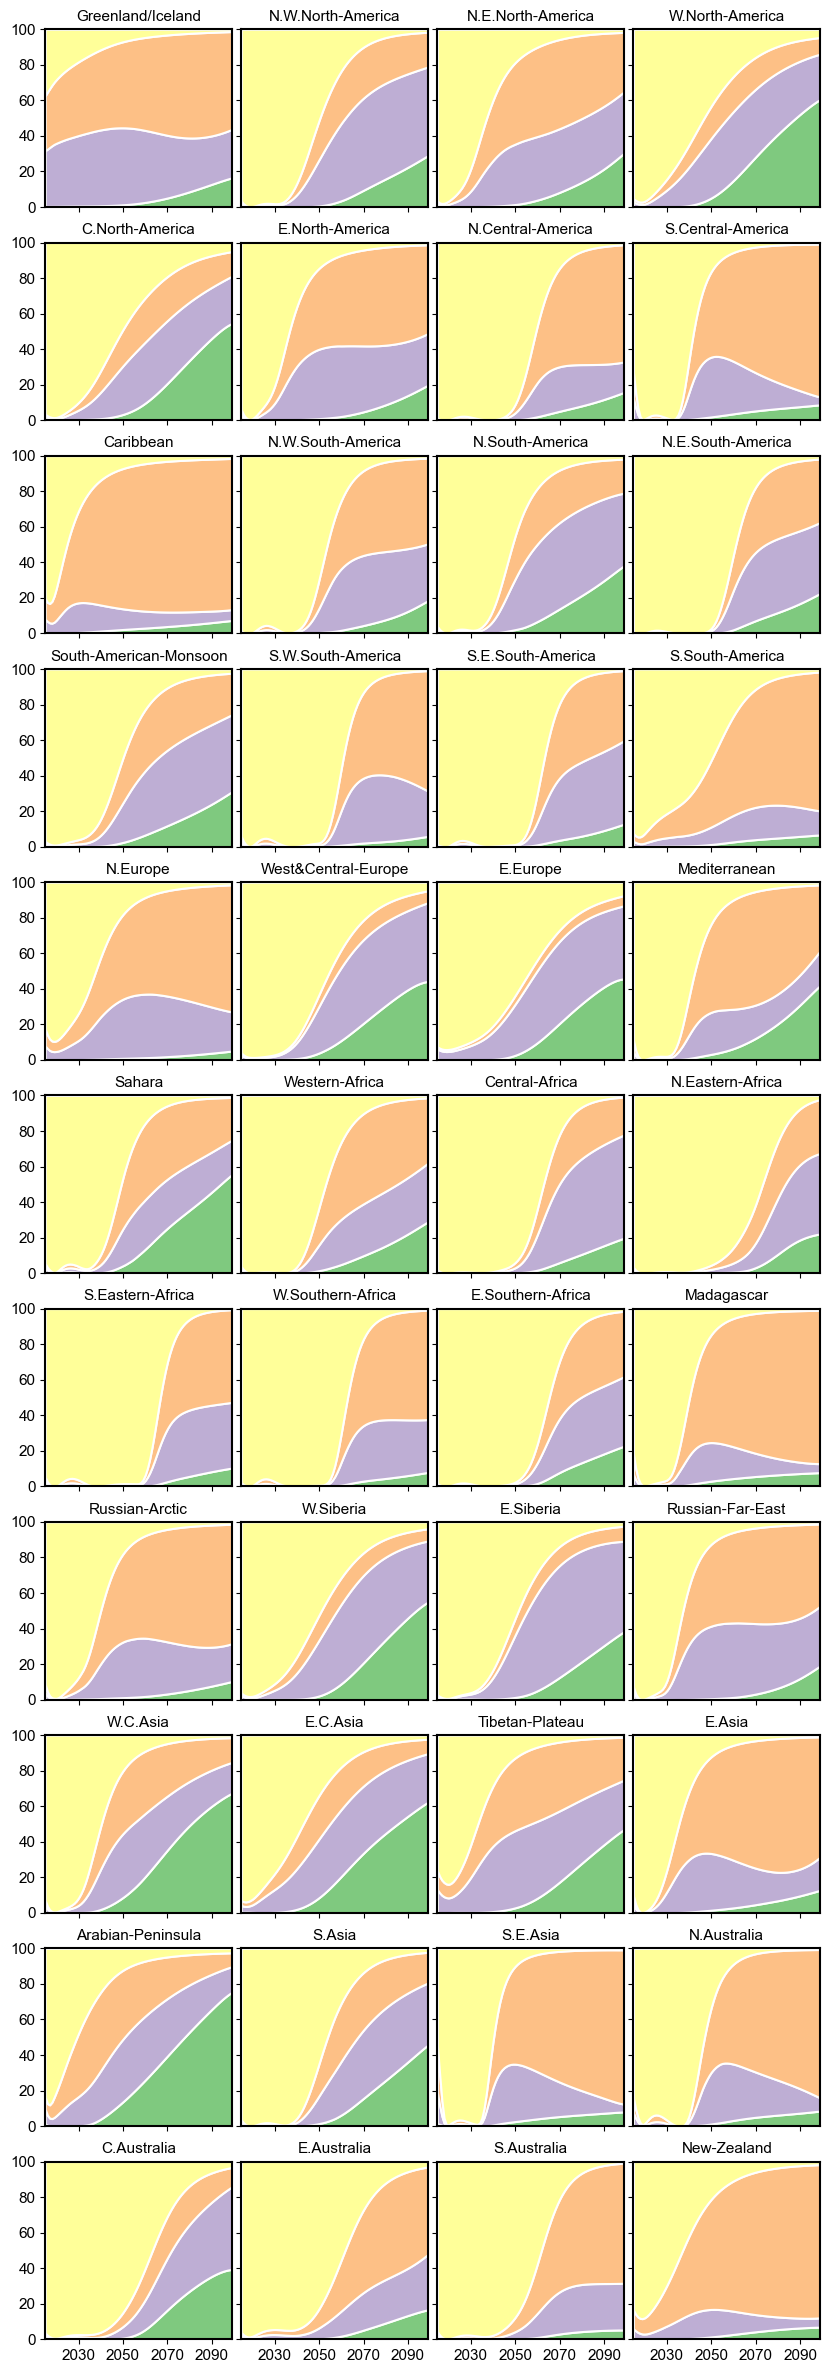

In [41]:
fig, axs = plt.subplots(
    11, 4, figsize=(10, 30), gridspec_kw={"wspace": 0.05}, sharex=True, sharey=True
)
axs = axs.flatten()

deg = 4

for i, region in enumerate(regionmask.defined_regions.ar6.land.abbrevs[:-2]):
    plot_uc_timeseries_region(
        "hot_spatial",
        "tasmax",
        "tasmax_q99gmfd_count",
        region,
        deg,
        "hs09",
        regionmask.defined_regions.ar6.land.names[i],
        "",
        "",
        False,
        axs[i],
    )

plt.show()